In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import SGD

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyImagesWidth"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (InceptionV3 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = InceptionV3(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
# Adding the top layer
predictions = Dense(num_classes, activation='softmax', name='predictions')(base_model.output)
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [10]:
# Fine-tuning the model (base_model + top layer) 
num_epochs=100
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='virussign-inceptionv3-finetune.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
init_weights = model.get_weights()

In [11]:
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    model.set_weights(init_weights)
    
    y_prob = model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Initial acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Initial acurracy: 0.0508
Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 95s - loss: 0.7196 - acc: 0.7880 - val_loss: 3.2301 - val_acc: 0.5312
Epoch 2/100
9112/9112 [==============================] - 74s - loss: 0.4083 - acc: 0.8802 - val_loss: 1.3972 - val_acc: 0.6338
Epoch 3/100
9112/9112 [==============================] - 75s - loss: 0.2874 - acc: 0.9167 - val_loss: 2.7780 - val_acc: 0.5508
Epoch 4/100
9112/9112 [==============================] - 76s - loss: 0.2387 - acc: 0.9270 - val_loss: 0.6960 - val_acc: 0.8184
Epoch 5/100
9112/9112 [==============================] - 76s - loss: 0.1768 - acc: 0.9469 - val_loss: 0.4848 - val_acc: 0.8750
Epoch 6/100
9112/9112 [==============================] - 76s - loss: 0.1753 - acc: 0.9457 - val_loss: 0.8187 - val_acc: 0.7334
Epoch 7/100
9112/9112 [==============================] - 76s - loss: 0.1370 - acc: 0.9573 - val_loss: 1.5082 - val_acc: 0.6465
Epoch 8/100
9112/9112 [===========

9112/9112 [==============================] - 76s - loss: 0.0163 - acc: 0.9957 - val_loss: 0.8388 - val_acc: 0.8701
Epoch 65/100
9112/9112 [==============================] - 76s - loss: 0.0094 - acc: 0.9973 - val_loss: 0.7805 - val_acc: 0.8613
Epoch 66/100
9112/9112 [==============================] - 76s - loss: 0.0088 - acc: 0.9967 - val_loss: 0.6114 - val_acc: 0.8994
Epoch 67/100
9112/9112 [==============================] - 76s - loss: 0.0104 - acc: 0.9966 - val_loss: 0.7838 - val_acc: 0.8809
Epoch 68/100
9112/9112 [==============================] - 76s - loss: 0.0252 - acc: 0.9926 - val_loss: 0.7594 - val_acc: 0.8281
Epoch 69/100
9112/9112 [==============================] - 76s - loss: 0.0348 - acc: 0.9895 - val_loss: 1.6605 - val_acc: 0.6807
Epoch 70/100
9112/9112 [==============================] - 76s - loss: 0.0124 - acc: 0.9965 - val_loss: 0.5021 - val_acc: 0.8975
Epoch 71/100
9112/9112 [==============================] - 76s - loss: 0.0024 - acc: 0.9992 - val_loss: 0.3643 - val_a

9114/9114 [==============================] - 76s - loss: 0.2710 - acc: 0.9167 - val_loss: 0.4109 - val_acc: 0.8787
Epoch 27/100
9114/9114 [==============================] - 76s - loss: 0.2453 - acc: 0.9246 - val_loss: 0.4121 - val_acc: 0.8816
Epoch 28/100
9114/9114 [==============================] - 76s - loss: 0.2382 - acc: 0.9256 - val_loss: 0.4757 - val_acc: 0.8650
Epoch 29/100
9114/9114 [==============================] - 76s - loss: 0.2113 - acc: 0.9348 - val_loss: 0.4464 - val_acc: 0.8816
Epoch 30/100
9114/9114 [==============================] - 76s - loss: 0.2012 - acc: 0.9365 - val_loss: 0.7169 - val_acc: 0.8386
Epoch 31/100
9114/9114 [==============================] - 76s - loss: 0.1832 - acc: 0.9391 - val_loss: 0.7899 - val_acc: 0.7691
Epoch 32/100
9114/9114 [==============================] - 76s - loss: 0.1648 - acc: 0.9455 - val_loss: 1.0667 - val_acc: 0.7710
Epoch 33/100
9114/9114 [==============================] - 76s - loss: 0.1856 - acc: 0.9403 - val_loss: 0.7735 - val_a

9114/9114 [==============================] - 76s - loss: 0.0035 - acc: 0.9989 - val_loss: 0.5725 - val_acc: 0.9149
Epoch 91/100
9114/9114 [==============================] - 76s - loss: 0.0041 - acc: 0.9988 - val_loss: 0.6660 - val_acc: 0.8973
Epoch 92/100
9114/9114 [==============================] - 76s - loss: 0.1075 - acc: 0.9686 - val_loss: 1.6645 - val_acc: 0.7025
Epoch 93/100
9114/9114 [==============================] - 76s - loss: 0.0649 - acc: 0.9787 - val_loss: 0.9023 - val_acc: 0.8297
Epoch 94/100
9114/9114 [==============================] - 76s - loss: 0.0168 - acc: 0.9951 - val_loss: 0.5998 - val_acc: 0.9041
Epoch 95/100
9114/9114 [==============================] - 76s - loss: 0.0310 - acc: 0.9902 - val_loss: 1.4034 - val_acc: 0.7681
Epoch 96/100
9114/9114 [==============================] - 76s - loss: 0.0150 - acc: 0.9952 - val_loss: 0.5516 - val_acc: 0.9100
Epoch 97/100
9114/9114 [==============================] - 76s - loss: 0.0063 - acc: 0.9986 - val_loss: 0.5715 - val_a

9116/9116 [==============================] - 76s - loss: 0.0424 - acc: 0.9883 - val_loss: 0.9480 - val_acc: 0.8137
Epoch 53/100
9116/9116 [==============================] - 76s - loss: 0.0299 - acc: 0.9908 - val_loss: 0.9309 - val_acc: 0.8196
Epoch 54/100
9116/9116 [==============================] - 76s - loss: 0.0320 - acc: 0.9900 - val_loss: 0.7661 - val_acc: 0.8667
Epoch 55/100
9116/9116 [==============================] - 76s - loss: 0.0241 - acc: 0.9927 - val_loss: 0.7392 - val_acc: 0.8765
Epoch 56/100
9116/9116 [==============================] - 76s - loss: 0.0144 - acc: 0.9966 - val_loss: 0.9052 - val_acc: 0.7971
Epoch 57/100
9116/9116 [==============================] - 76s - loss: 0.0317 - acc: 0.9914 - val_loss: 2.1909 - val_acc: 0.6255
Epoch 58/100
9116/9116 [==============================] - 76s - loss: 0.1201 - acc: 0.9650 - val_loss: 0.4977 - val_acc: 0.9029
Epoch 59/100
9116/9116 [==============================] - 76s - loss: 0.0296 - acc: 0.9921 - val_loss: 0.5996 - val_a

9120/9120 [==============================] - 76s - loss: 0.3455 - acc: 0.8912 - val_loss: 0.8903 - val_acc: 0.7589
Epoch 15/100
9120/9120 [==============================] - 76s - loss: 0.3055 - acc: 0.9033 - val_loss: 0.4886 - val_acc: 0.8671
Epoch 16/100
9120/9120 [==============================] - 76s - loss: 0.2915 - acc: 0.9060 - val_loss: 1.0162 - val_acc: 0.7697
Epoch 17/100
9120/9120 [==============================] - 76s - loss: 0.2364 - acc: 0.9254 - val_loss: 0.4451 - val_acc: 0.8829
Epoch 18/100
9120/9120 [==============================] - 76s - loss: 0.2266 - acc: 0.9262 - val_loss: 0.6022 - val_acc: 0.8376
Epoch 19/100
9120/9120 [==============================] - 76s - loss: 0.2116 - acc: 0.9315 - val_loss: 0.8908 - val_acc: 0.7933
Epoch 20/100
9120/9120 [==============================] - 76s - loss: 0.1894 - acc: 0.9393 - val_loss: 0.4549 - val_acc: 0.8898
Epoch 21/100
9120/9120 [==============================] - 76s - loss: 0.1843 - acc: 0.9432 - val_loss: 1.1565 - val_a

9120/9120 [==============================] - 76s - loss: 0.0141 - acc: 0.9955 - val_loss: 0.5500 - val_acc: 0.9045
Epoch 79/100
9120/9120 [==============================] - 76s - loss: 0.0265 - acc: 0.9952 - val_loss: 1.9558 - val_acc: 0.7254
Epoch 80/100
9120/9120 [==============================] - 76s - loss: 0.0216 - acc: 0.9936 - val_loss: 0.8925 - val_acc: 0.8268
Epoch 81/100
9120/9120 [==============================] - 76s - loss: 0.0337 - acc: 0.9897 - val_loss: 3.2758 - val_acc: 0.6407
Epoch 82/100
9120/9120 [==============================] - 76s - loss: 0.0360 - acc: 0.9906 - val_loss: 1.2526 - val_acc: 0.7874
Epoch 83/100
9120/9120 [==============================] - 76s - loss: 0.0252 - acc: 0.9928 - val_loss: 0.5569 - val_acc: 0.9035
Epoch 84/100
9120/9120 [==============================] - 76s - loss: 0.0168 - acc: 0.9936 - val_loss: 0.5030 - val_acc: 0.9183
Epoch 85/100
9120/9120 [==============================] - 76s - loss: 0.0184 - acc: 0.9941 - val_loss: 0.7916 - val_a

9120/9120 [==============================] - 76s - loss: 0.0250 - acc: 0.9925 - val_loss: 0.7093 - val_acc: 0.8415
Epoch 41/100
9120/9120 [==============================] - 76s - loss: 0.0263 - acc: 0.9921 - val_loss: 0.6070 - val_acc: 0.9006
Epoch 42/100
9120/9120 [==============================] - 76s - loss: 0.0229 - acc: 0.9937 - val_loss: 0.6789 - val_acc: 0.8720
Epoch 43/100
9120/9120 [==============================] - 76s - loss: 0.0427 - acc: 0.9871 - val_loss: 1.0713 - val_acc: 0.8396
Epoch 44/100
9120/9120 [==============================] - 76s - loss: 0.0310 - acc: 0.9912 - val_loss: 0.6535 - val_acc: 0.8770
Epoch 45/100
9120/9120 [==============================] - 76s - loss: 0.0481 - acc: 0.9850 - val_loss: 0.8628 - val_acc: 0.8740
Epoch 46/100
9120/9120 [==============================] - 76s - loss: 0.0344 - acc: 0.9879 - val_loss: 0.9582 - val_acc: 0.8760
Epoch 47/100
9120/9120 [==============================] - 76s - loss: 0.0221 - acc: 0.9924 - val_loss: 2.3714 - val_a

9125/9125 [==============================] - 76s - loss: 2.6665 - acc: 0.1942 - val_loss: 2.7972 - val_acc: 0.2018
Epoch 3/100
9125/9125 [==============================] - 83s - loss: 2.4302 - acc: 0.2343 - val_loss: 2.7786 - val_acc: 0.1533
Epoch 4/100
9125/9125 [==============================] - 83s - loss: 2.1227 - acc: 0.3098 - val_loss: 2.8106 - val_acc: 0.2038
Epoch 5/100
9125/9125 [==============================] - 84s - loss: 1.7019 - acc: 0.4256 - val_loss: 2.3151 - val_acc: 0.2334
Epoch 6/100
9125/9125 [==============================] - 86s - loss: 1.2069 - acc: 0.6235 - val_loss: 1.7366 - val_acc: 0.4411
Epoch 7/100
9125/9125 [==============================] - 84s - loss: 0.9705 - acc: 0.6965 - val_loss: 1.2371 - val_acc: 0.6053
Epoch 8/100
9125/9125 [==============================] - 77s - loss: 0.8054 - acc: 0.7448 - val_loss: 2.6170 - val_acc: 0.4016
Epoch 9/100
9125/9125 [==============================] - 87s - loss: 0.7131 - acc: 0.7725 - val_loss: 2.5513 - val_acc: 0.4

9125/9125 [==============================] - 114s - loss: 0.0225 - acc: 0.9923 - val_loss: 1.9091 - val_acc: 0.6588
Epoch 66/100
9125/9125 [==============================] - 84s - loss: 0.0224 - acc: 0.9927 - val_loss: 2.2184 - val_acc: 0.7458
Epoch 67/100
9125/9125 [==============================] - 84s - loss: 0.0270 - acc: 0.9915 - val_loss: 0.6743 - val_acc: 0.8843
Epoch 68/100
9125/9125 [==============================] - 85s - loss: 0.0347 - acc: 0.9885 - val_loss: 3.3908 - val_acc: 0.6014
Epoch 69/100
9125/9125 [==============================] - 83s - loss: 0.0299 - acc: 0.9895 - val_loss: 0.8080 - val_acc: 0.8922
Epoch 70/100
9125/9125 [==============================] - 81s - loss: 0.0194 - acc: 0.9938 - val_loss: 0.8311 - val_acc: 0.8576
Epoch 71/100
9125/9125 [==============================] - 81s - loss: 0.0225 - acc: 0.9923 - val_loss: 1.3362 - val_acc: 0.7587
Epoch 72/100
9125/9125 [==============================] - 80s - loss: 0.0218 - acc: 0.9922 - val_loss: 1.6921 - val_

9127/9127 [==============================] - 76s - loss: 0.1942 - acc: 0.9452 - val_loss: 0.8577 - val_acc: 0.7750
Epoch 28/100
9127/9127 [==============================] - 76s - loss: 0.1695 - acc: 0.9507 - val_loss: 1.9488 - val_acc: 0.6819
Epoch 29/100
9127/9127 [==============================] - 76s - loss: 0.1407 - acc: 0.9573 - val_loss: 1.4404 - val_acc: 0.7066
Epoch 30/100
9127/9127 [==============================] - 76s - loss: 0.1471 - acc: 0.9546 - val_loss: 1.1065 - val_acc: 0.7393
Epoch 31/100
9127/9127 [==============================] - 76s - loss: 0.1032 - acc: 0.9697 - val_loss: 0.8432 - val_acc: 0.7839
Epoch 32/100
9127/9127 [==============================] - 76s - loss: 0.0897 - acc: 0.9736 - val_loss: 4.0595 - val_acc: 0.5094
Epoch 33/100
9127/9127 [==============================] - 76s - loss: 0.0977 - acc: 0.9725 - val_loss: 2.8305 - val_acc: 0.6125
Epoch 34/100
9127/9127 [==============================] - 76s - loss: 0.1186 - acc: 0.9641 - val_loss: 5.2313 - val_a

9127/9127 [==============================] - 90s - loss: 0.0096 - acc: 0.9967 - val_loss: 0.8268 - val_acc: 0.8662
Epoch 92/100
9127/9127 [==============================] - 93s - loss: 0.0102 - acc: 0.9966 - val_loss: 0.8258 - val_acc: 0.8573
Epoch 93/100
9127/9127 [==============================] - 91s - loss: 0.0062 - acc: 0.9984 - val_loss: 0.5973 - val_acc: 0.9019
Epoch 94/100
9127/9127 [==============================] - 93s - loss: 0.0024 - acc: 0.9997 - val_loss: 0.8411 - val_acc: 0.8959
Epoch 95/100
9127/9127 [==============================] - 94s - loss: 0.0132 - acc: 0.9979 - val_loss: 0.8800 - val_acc: 0.8147
Epoch 96/100
9127/9127 [==============================] - 94s - loss: 0.0085 - acc: 0.9972 - val_loss: 3.2134 - val_acc: 0.6383
Epoch 97/100
9127/9127 [==============================] - 86s - loss: 0.0500 - acc: 0.9862 - val_loss: 5.3099 - val_acc: 0.4063
Epoch 98/100
9127/9127 [==============================] - 86s - loss: 0.0249 - acc: 0.9925 - val_loss: 1.0980 - val_a

9128/9128 [==============================] - 77s - loss: 0.0386 - acc: 0.9884 - val_loss: 1.0321 - val_acc: 0.8304
Epoch 54/100
9128/9128 [==============================] - 77s - loss: 0.0501 - acc: 0.9847 - val_loss: 2.9861 - val_acc: 0.6488
Epoch 55/100
9128/9128 [==============================] - 76s - loss: 0.0636 - acc: 0.9805 - val_loss: 1.5251 - val_acc: 0.7907
Epoch 56/100
9128/9128 [==============================] - 77s - loss: 0.0516 - acc: 0.9842 - val_loss: 3.2186 - val_acc: 0.5347
Epoch 57/100
9128/9128 [==============================] - 77s - loss: 0.0344 - acc: 0.9896 - val_loss: 0.8631 - val_acc: 0.8740
Epoch 58/100
9128/9128 [==============================] - 76s - loss: 0.0263 - acc: 0.9930 - val_loss: 1.4933 - val_acc: 0.7579
Epoch 59/100
9128/9128 [==============================] - 77s - loss: 0.0454 - acc: 0.9872 - val_loss: 2.7517 - val_acc: 0.5516
Epoch 60/100
9128/9128 [==============================] - 77s - loss: 0.0324 - acc: 0.9896 - val_loss: 3.0602 - val_a

9130/9130 [==============================] - 82s - loss: 0.1425 - acc: 0.9568 - val_loss: 0.7181 - val_acc: 0.8131
Epoch 16/100
9130/9130 [==============================] - 85s - loss: 0.1257 - acc: 0.9619 - val_loss: 1.8755 - val_acc: 0.6193
Epoch 17/100
9130/9130 [==============================] - 85s - loss: 0.1160 - acc: 0.9654 - val_loss: 0.7216 - val_acc: 0.8072
Epoch 18/100
9130/9130 [==============================] - 86s - loss: 0.0936 - acc: 0.9701 - val_loss: 0.7900 - val_acc: 0.8082
Epoch 19/100
9130/9130 [==============================] - 81s - loss: 0.0825 - acc: 0.9742 - val_loss: 1.2176 - val_acc: 0.6620
Epoch 20/100
9130/9130 [==============================] - 85s - loss: 0.0718 - acc: 0.9778 - val_loss: 0.8382 - val_acc: 0.8588
Epoch 21/100
9130/9130 [==============================] - 82s - loss: 0.0570 - acc: 0.9816 - val_loss: 0.6230 - val_acc: 0.8618
Epoch 22/100
9130/9130 [==============================] - 85s - loss: 0.0632 - acc: 0.9813 - val_loss: 3.2054 - val_a

9130/9130 [==============================] - 75s - loss: 0.0038 - acc: 0.9988 - val_loss: 1.1540 - val_acc: 0.8509
Epoch 80/100
9130/9130 [==============================] - 76s - loss: 0.0172 - acc: 0.9949 - val_loss: 1.3588 - val_acc: 0.7366
Epoch 81/100
9130/9130 [==============================] - 75s - loss: 0.0732 - acc: 0.9778 - val_loss: 4.9079 - val_acc: 0.4523
Epoch 82/100
9130/9130 [==============================] - 75s - loss: 0.0408 - acc: 0.9883 - val_loss: 2.3952 - val_acc: 0.6441
Epoch 83/100
9130/9130 [==============================] - 75s - loss: 0.0362 - acc: 0.9888 - val_loss: 0.7245 - val_acc: 0.8579
Epoch 84/100
9130/9130 [==============================] - 75s - loss: 0.0094 - acc: 0.9974 - val_loss: 0.8358 - val_acc: 0.8748
Epoch 85/100
9130/9130 [==============================] - 75s - loss: 0.0031 - acc: 0.9992 - val_loss: 0.4216 - val_acc: 0.9264
Epoch 86/100
9130/9130 [==============================] - 75s - loss: 0.0013 - acc: 0.9998 - val_loss: 0.4206 - val_a

9132/9132 [==============================] - 79s - loss: 0.0425 - acc: 0.9876 - val_loss: 4.2269 - val_acc: 0.4432
Epoch 42/100
9132/9132 [==============================] - 77s - loss: 0.0596 - acc: 0.9817 - val_loss: 5.9233 - val_acc: 0.3765
Epoch 43/100
9132/9132 [==============================] - 77s - loss: 0.0240 - acc: 0.9924 - val_loss: 0.9974 - val_acc: 0.8307
Epoch 44/100
9132/9132 [==============================] - 77s - loss: 0.0130 - acc: 0.9961 - val_loss: 0.8845 - val_acc: 0.8277
Epoch 45/100
9132/9132 [==============================] - 77s - loss: 0.4155 - acc: 0.9079 - val_loss: 9.9913 - val_acc: 0.1026
Epoch 46/100
9132/9132 [==============================] - 80s - loss: 0.6555 - acc: 0.8603 - val_loss: 5.5112 - val_acc: 0.2570
Epoch 47/100
9132/9132 [==============================] - 90s - loss: 0.2178 - acc: 0.9323 - val_loss: 1.0013 - val_acc: 0.7261
Epoch 48/100
9132/9132 [==============================] - 79s - loss: 0.1182 - acc: 0.9622 - val_loss: 0.3380 - val_a

In [12]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.8377


In [13]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Accuracy.pdf', format='pdf')
    plt.show()

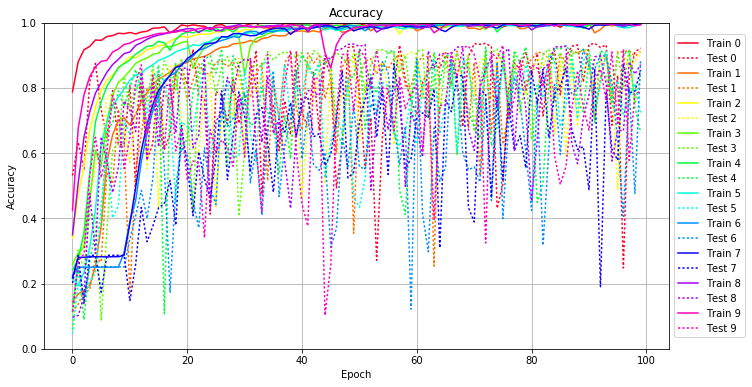

In [14]:
plot_acc(history)

In [15]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.savefig('Softmax-Loss.pdf', format='pdf')
    plt.show()

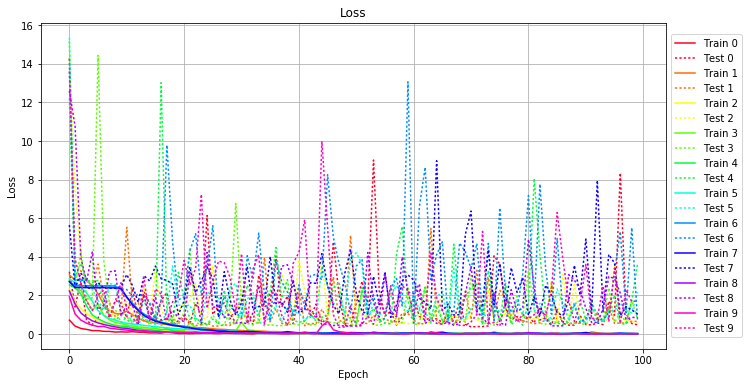

In [16]:
plot_loss(history)

Plotting the confusion matrix


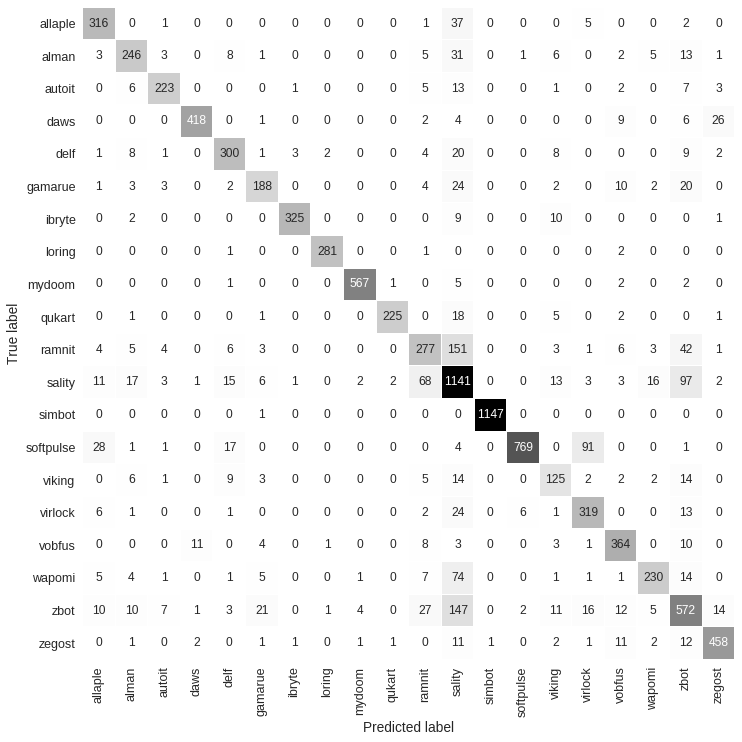

In [17]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 12}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


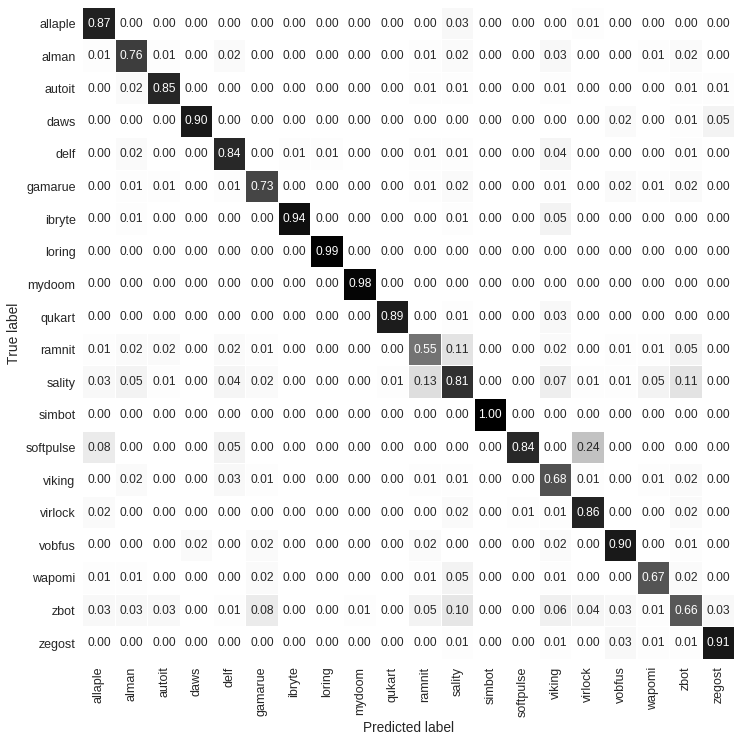

In [18]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 12}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [19]:
for h in history:
    print(h.history)

{'acc': [0.78797190517998239, 0.88015803346726018, 0.91670324851589524, 0.92701931518876213, 0.94688323100896343, 0.94567603160667257, 0.95730904307252385, 0.96027216856892006, 0.96740561901633415, 0.96619841977103538, 0.9698200175592625, 0.96543020193151885, 0.971136962352247, 0.97355136084284455, 0.98287971915646122, 0.98364793678665496, 0.98705004400281759, 0.96817383680351998, 0.97947761194029848, 0.99308604038630377, 0.98979367866549606, 0.99308604038630377, 0.99056189640035119, 0.98891571553994728, 0.97848990342405617, 0.9918788410886743, 0.99407374890254607, 0.98529411775172016, 0.9873792801748984, 0.98562335381913957, 0.99122036874451269, 0.99648814749780512, 0.99846356463495112, 0.98562335392380096, 0.98046532045654078, 0.98474539079825218, 0.98935469710272173, 0.99714661984196662, 0.99604916593503068, 0.99396400351185255, 0.99506145741878838, 0.99308604038630377, 0.99023266033293178, 0.99045215100965756, 0.99517120280948201, 0.99198858658402922, 0.99100087806778692, 0.9920983

In [20]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

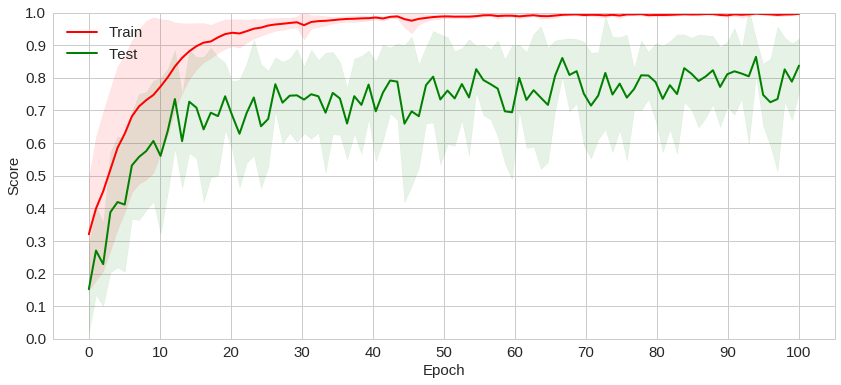

In [21]:
plot_mean_acc(history)

In [22]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

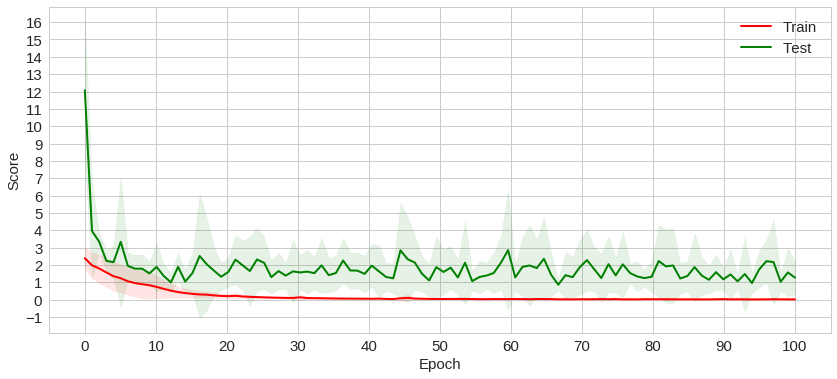

In [23]:
plot_mean_loss(history)

In [25]:
history = [{'acc': [0.78797190517998239, 0.88015803346726018, 0.91670324851589524, 0.92701931518876213, 0.94688323100896343, 0.94567603160667257, 0.95730904307252385, 0.96027216856892006, 0.96740561901633415, 0.96619841977103538, 0.9698200175592625, 0.96543020193151885, 0.971136962352247, 0.97355136084284455, 0.98287971915646122, 0.98364793678665496, 0.98705004400281759, 0.96817383680351998, 0.97947761194029848, 0.99308604038630377, 0.98979367866549606, 0.99308604038630377, 0.99056189640035119, 0.98891571553994728, 0.97848990342405617, 0.9918788410886743, 0.99407374890254607, 0.98529411775172016, 0.9873792801748984, 0.98562335381913957, 0.99122036874451269, 0.99648814749780512, 0.99846356463495112, 0.98562335392380096, 0.98046532045654078, 0.98474539079825218, 0.98935469710272173, 0.99714661984196662, 0.99604916593503068, 0.99396400351185255, 0.99506145741878838, 0.99308604038630377, 0.99023266033293178, 0.99045215100965756, 0.99517120280948201, 0.99198858658402922, 0.99100087806778692, 0.99209833187006147, 0.99593942054433715, 0.99813432846287031, 0.99703687445127309, 0.99209833187006147, 0.98781826163301145, 0.99045215111431895, 0.98683055322143043, 0.99473222124670768, 0.99692712906057945, 0.99769534679543459, 0.99484196663740121, 0.99495171202809485, 0.990891132572432, 0.99561018437225635, 0.99615891132572432, 0.99571992976294998, 0.99725636523266026, 0.99670763827919229, 0.99659789299316004, 0.99264705892819072, 0.98946444259807664, 0.99648814749780512, 0.99923178226514486, 0.9996707638279192, 0.99989025460930636, 0.9996707638279192, 0.990891132572432, 0.98683055322143043, 0.99319578577699741, 0.99890254609306406, 0.99626865671641796, 0.99747585601404742, 0.99835381913959609, 0.99791483757682176, 0.99824407374890256, 0.99550043898156282, 0.99517120286181271, 0.98595258999122037, 0.99802458296751539, 0.99791483757682176, 0.99780509218612823, 0.99703687445127309, 0.99857330992098337, 0.9996707638279192, 0.99956101843722567, 0.99989025460930636, 0.99681738366988581, 0.9938542582258203, 0.98946444249341525, 0.99297629504794083, 0.99659789288849865, 0.99923178226514486], 'loss': [0.71962183700830296, 0.40833405282960011, 0.2873829700006949, 0.23872250020242344, 0.17680774417176803, 0.17526922469158984, 0.13698492636797824, 0.13350149358216348, 0.098932558633027315, 0.10931277275085449, 0.098378560436305718, 0.11883294275578331, 0.094025495997691388, 0.085527263552316768, 0.05554509061021539, 0.056021222962872749, 0.044741736522191336, 0.10810256922409868, 0.066624310937537581, 0.023681219544137409, 0.030461768102133035, 0.021159852863901849, 0.028990388264686615, 0.036659357023504716, 0.065361040628811998, 0.026993048446121298, 0.02136055614684379, 0.042762178123075777, 0.038128524458999037, 0.04356068472471579, 0.028680142693882246, 0.011049025220354109, 0.0055877160972075844, 0.045120636734931996, 0.063228554445579718, 0.047274594713996726, 0.034126181231895043, 0.010495110471647877, 0.014303058577591883, 0.020109110004681508, 0.020880885517743478, 0.026329849488114166, 0.031533339930227298, 0.029613646448095582, 0.01487230733355885, 0.026435450432996679, 0.023903872854549753, 0.02745386178466664, 0.014973431537103617, 0.0060070718535777312, 0.0089116023199070516, 0.025468320725889407, 0.049923352029622649, 0.029333285817200249, 0.040746467417765074, 0.019682159484016585, 0.010347041806696298, 0.008607613466127307, 0.0199304555099796, 0.017511647723858836, 0.028750358797001462, 0.015191060404437967, 0.011744428071517602, 0.016256673443505232, 0.0094269937390260832, 0.0087813045542329046, 0.010364905599696043, 0.025163884515055603, 0.034847336432253052, 0.012422517447457346, 0.0024259797605397457, 0.0010969480940909799, 0.00088951822517445238, 0.0014030466386681436, 0.033671654380162522, 0.041746891615135534, 0.022281640794093838, 0.0048500045618251669, 0.016052346825480086, 0.0081427626560554162, 0.0049714890301753535, 0.0064026650798041373, 0.007490727544002377, 0.014772711700444618, 0.020005367395997085, 0.048206479108955341, 0.0067023301451210231, 0.0083350497810517569, 0.009358367478332701, 0.011414320597443909, 0.0052612647241539207, 0.0026495721923184105, 0.0017095153100656847, 0.00089466691910669138, 0.010484208720008993, 0.024054820632614781, 0.036223429840636999, 0.020905391880085396, 0.011619968949627014, 0.0026372481253060663], 'val_acc': [0.53125, 0.6337890625, 0.55078125, 0.818359375, 0.875, 0.7333984375, 0.646484375, 0.7919921875, 0.6259765625, 0.6259765625, 0.8076171875, 0.5029296875, 0.80859375, 0.580078125, 0.6298828125, 0.8505859375, 0.6103515625, 0.6572265625, 0.8515625, 0.8623046875, 0.8095703125, 0.91796875, 0.77734375, 0.7646484375, 0.4130859375, 0.7880859375, 0.779296875, 0.689453125, 0.828125, 0.69140625, 0.7587890625, 0.8095703125, 0.9150390625, 0.4736328125, 0.6923828125, 0.74609375, 0.607421875, 0.759765625, 0.65625, 0.91015625, 0.7236328125, 0.6796875, 0.849609375, 0.6689453125, 0.8896484375, 0.8359375, 0.4931640625, 0.6279296875, 0.923828125, 0.92578125, 0.783203125, 0.5517578125, 0.7080078125, 0.271484375, 0.6494140625, 0.8056640625, 0.8037109375, 0.9306640625, 0.82421875, 0.759765625, 0.7197265625, 0.81640625, 0.8525390625, 0.8701171875, 0.861328125, 0.8994140625, 0.880859375, 0.828125, 0.6806640625, 0.8974609375, 0.935546875, 0.93359375, 0.9365234375, 0.92578125, 0.4306640625, 0.5048828125, 0.80078125, 0.876953125, 0.85546875, 0.9111328125, 0.841796875, 0.9052734375, 0.7138671875, 0.859375, 0.9150390625, 0.7783203125, 0.896484375, 0.927734375, 0.931640625, 0.8173828125, 0.9326171875, 0.9365234375, 0.923828125, 0.931640625, 0.685546875, 0.837890625, 0.248046875, 0.83203125, 0.91015625, 0.921875], 'val_loss': [3.2301007574424148, 1.3972420759964734, 2.7779823131859303, 0.6960304605163401, 0.48483862713328563, 0.81871110526844859, 1.5081721358001232, 0.83339425568487968, 1.7484806329011917, 1.5911765806376934, 0.84152249088219833, 2.3715666178613901, 0.7979021487863065, 2.1958329408080317, 1.5837152681706357, 0.61335814074914197, 1.7397415852174163, 2.1486080691684037, 0.52630603103898466, 0.68435038786992664, 0.96008393688009619, 0.48864698809848051, 1.5855757903482299, 1.0053640874102712, 6.1374093594495207, 1.0087649382767268, 1.4592521330205273, 1.6068774377927184, 0.7849370869807899, 1.2908138590944702, 1.7534669412343646, 0.9860201387032248, 0.48514454169207966, 3.0415987065061927, 1.408198659773916, 1.5920865350053646, 4.041390883969143, 1.4048859405484109, 1.9663818897679448, 0.53004858459462412, 2.0765007111203886, 1.7682587984018028, 0.88466350583621534, 1.5516515257477295, 0.57806095280557201, 0.83271182759290241, 4.7719529078722189, 1.9895930613856763, 0.43878700407969973, 0.42892368477009768, 1.6069367905056424, 2.7284724878863935, 1.5963329500518739, 9.0150967415081737, 2.2284375170711428, 0.91855856515758205, 1.1866441737921605, 0.45824041809828486, 0.88864847872282837, 1.1287695025093853, 1.867092052474618, 0.90959768019092735, 0.72983103262959048, 0.8388371903274674, 0.78054838507881641, 0.61140901341474319, 0.78383734253293369, 0.75940705360125804, 1.6604962106794119, 0.5021329109117687, 0.36433019618261575, 0.38427207666939367, 0.38439827477767885, 0.41872055713975165, 4.0493204635567963, 3.6190757844597101, 1.3284331561712293, 0.73622839475336832, 0.90124993420613464, 0.62266640263581507, 0.91935456783097891, 0.57062821650124818, 1.3930817800574005, 0.82769238756009145, 0.45940311212166307, 1.2750944548079133, 0.55155803548404947, 0.45969546769367753, 0.4635328013293929, 0.94466627098154277, 0.49010767433395586, 0.46963217644470845, 0.5710626470708462, 0.48346887016405304, 1.6991190428065579, 0.97110175777925178, 8.344081848859787, 1.0649272426384009, 0.54453141518692405, 0.47282568866842478]},
{'acc': [0.14439324116743471, 0.1677638797683362, 0.17928461709225521, 0.19343866583467551, 0.25345622122431627, 0.3762343647921062, 0.57285494856178332, 0.6564625851648116, 0.69980250165889946, 0.70825104243090364, 0.68597761701015048, 0.71955233726005474, 0.75817423750230928, 0.78626289235831404, 0.81018213765883307, 0.82664033365741429, 0.83673469407374801, 0.84858459532457087, 0.86537195535142453, 0.8749177091237299, 0.87733157789704563, 0.88874259391635668, 0.89291200372035862, 0.8962036429566983, 0.90542023263533233, 0.91672152760836123, 0.92462146168401793, 0.92560895344184002, 0.93482554323819222, 0.93647136284328225, 0.939104674232354, 0.9454685100369582, 0.94031160869749064, 0.95073513294589973, 0.95424621471951665, 0.9614878209479053, 0.95918367356094636, 0.95951283749766014, 0.97026552574818192, 0.97300855835357303, 0.9749835418038183, 0.97114329611964723, 0.97498354201309512, 0.97114329611964723, 0.98321263989466756, 0.98398068914137204, 0.98233486954936178, 0.97026552565662338, 0.97399605012447499, 0.97981127945508828, 0.98474873829651799, 0.98694316446715757, 0.9752029846026915, 0.98639455782312924, 0.98858898398068906, 0.98880842668800362, 0.989247311827957, 0.99495281983761241, 0.99089313153768543, 0.99045424639773205, 0.9748738206005787, 0.98156682027649766, 0.99133201667763882, 0.98562650866798329, 0.98815009874917714, 0.9946236559139785, 0.9962694755321484, 0.99791529515031818, 0.99758613122668427, 0.98266403344683617, 0.98343208260198212, 0.97882378757954791, 0.98815009884073568, 0.99374588563407174, 0.99220978714066277, 0.99583059030063636, 0.99330700021944263, 0.99374588563407174, 0.98123765645750216, 0.98321263989466756, 0.99440421338978113, 0.99594031160851437, 0.99846390168970811, 0.99681808216309686, 0.99034452490673686, 0.99396532806671056, 0.99758613122668427, 0.99923195084485406, 0.99912222953697605, 0.99890278692122014, 0.99879306579645932, 0.96861970605153325, 0.97871406627167001, 0.99506254114549042, 0.99023480359885885, 0.99517226245336843, 0.99857362299758612, 0.99901250822909804, 0.99637919684002629, 0.99594031160851437], 'loss': [3.0660283251082867, 2.7842493676710265, 2.8297036894324687, 2.7681219120519529, 2.5188943280288467, 2.0799965229582731, 1.5243542555892104, 1.2151399934817648, 1.0682063872468348, 1.0289264318057261, 1.1901440231690732, 0.99291698568244502, 0.80406140700384843, 0.68400334028107357, 0.61310852302488905, 0.56375917985247292, 0.52234972128879609, 0.48991901671282156, 0.44255078451032304, 0.40571196637238383, 0.38381488119297602, 0.34708883451321992, 0.33471666306865461, 0.33016180863944433, 0.30086772062419043, 0.27096989531121496, 0.24529920716230247, 0.23817994361361156, 0.2112745134381053, 0.20115811724868918, 0.18322285975127045, 0.16476629324223038, 0.18559765997544073, 0.15448746720191181, 0.14361827168674984, 0.12399030361215822, 0.12430784704328394, 0.12035420881647642, 0.098430983611031642, 0.079906243270940369, 0.071968277554574023, 0.089302141780991398, 0.076120419697932096, 0.085428286993715463, 0.054878632078797035, 0.048426988543008594, 0.055981472870328855, 0.08992110142745495, 0.079293679623376759, 0.057712662795839378, 0.048486691524166535, 0.039057275512931589, 0.076903760155251286, 0.046468378111494457, 0.039593675726236205, 0.036863074784075349, 0.032465112659224284, 0.018356297302084559, 0.029665112777455534, 0.03004653429024335, 0.070923495775308168, 0.056845016588267065, 0.028740567560860509, 0.046483727816043929, 0.035877975443734104, 0.017450008245517325, 0.013425806869374822, 0.0081431933890007118, 0.0087455558806816391, 0.055217419196527624, 0.052848934779008649, 0.064905704599546643, 0.036190198213254407, 0.020875679508476162, 0.022445239880201338, 0.015076295501497954, 0.02167634600567038, 0.020305418135753216, 0.055035460414967832, 0.05291866952416871, 0.018932149622696442, 0.013158702300234056, 0.004865088267890511, 0.012223524519499651, 0.0300279970213179, 0.017838834739375604, 0.010616533661276325, 0.0039165269742158417, 0.002978190750460798, 0.0035086585279690647, 0.0040700974699358307, 0.10746341974544793, 0.064941611934593454, 0.016802176117033767, 0.031006231792851554, 0.01500554217729903, 0.0063244319509241521, 0.0042523200642493294, 0.011026041631071628, 0.011599704632061433], 'val_acc': [0.11252446183953033, 0.13698630136986301, 0.17514677045396629, 0.18003913882660538, 0.27886496959600432, 0.26614481385673328, 0.53913894208210089, 0.50587084110818958, 0.7338551819441137, 0.63111545789964973, 0.16927592850011389, 0.54794520431302063, 0.65655577206098403, 0.79843444157019983, 0.8072407029846177, 0.79452054771191916, 0.79060665210399139, 0.73874755311618812, 0.85127201215628312, 0.84344422257343155, 0.76712328510508376, 0.82387475281545564, 0.8737769045241891, 0.84540117253529345, 0.84246575085850839, 0.87866927429654595, 0.88160469410704079, 0.86497064229326937, 0.88160469585668788, 0.83855185466736493, 0.76908023226751043, 0.77103718129622723, 0.84148727914358534, 0.87573385448605112, 0.51467710068547801, 0.83170254146516209, 0.70450097684057722, 0.87769079978218756, 0.90410958740809189, 0.73972602389796605, 0.67025440243125667, 0.9070450062854416, 0.87573385168661577, 0.89823874685395722, 0.767123286971374, 0.83561643672316044, 0.60273972626068351, 0.86399217244463655, 0.89334637708160047, 0.35420743488285639, 0.83365948676129842, 0.88160469492354276, 0.88943248275674724, 0.84246574992536327, 0.87769079884904233, 0.85812133002421165, 0.88845400730924362, 0.90215263744622998, 0.80626222858690233, 0.80430528305747973, 0.87084148378054926, 0.89921721763573514, 0.8953033223777368, 0.25342465636781519, 0.8913894299191738, 0.90802347893350976, 0.81017612547790463, 0.91291584952236859, 0.82485322453037868, 0.67710371749974974, 0.8776908037480543, 0.53033268078432627, 0.90313111196058837, 0.66340508642961837, 0.87769079791589721, 0.62720156579101627, 0.72407044694848255, 0.85812132629163107, 0.86399216777891097, 0.87279843187612094, 0.88747553641082255, 0.90998042609593643, 0.90606653177108321, 0.88845400917553385, 0.76125244536745107, 0.90410958729144875, 0.87866927336340084, 0.91389432310358187, 0.90802347893350976, 0.91487279400200294, 0.89726027222295568, 0.7025440292115781, 0.82974559523588054, 0.90410958729144875, 0.76810175682000681, 0.90998042702908155, 0.91095890235994192, 0.91389432042078966, 0.8972602714064537, 0.91095889967714971], 'val_loss': [14.304415432207739, 2.8988513540615073, 3.2857118618698271, 2.7872250504689675, 2.4158302494224504, 3.6228122057980054, 1.7616729078460813, 1.6481954407551984, 0.89621090585704888, 1.1636246328484523, 5.5327549391296742, 1.4282252154588233, 1.6250521088212204, 0.67429047837532663, 0.58571742250494763, 0.62922778573988003, 0.6935533103760908, 0.80725078112691817, 0.50591647076746726, 0.58185148317869861, 0.86266836807689462, 0.61840086253159432, 0.42935181209186929, 0.48695813093895779, 0.57501452560527455, 0.41091565984536377, 0.41205617517903592, 0.47574642825477126, 0.44638604727501247, 0.71693786302191409, 0.78986124441286443, 1.066732310050271, 0.77351309630268938, 0.5461037945423326, 3.9608965982662956, 0.62967058572619283, 1.3216025225103718, 0.55746648117713993, 0.43974296743033814, 1.1049745237407387, 2.399798726907215, 0.43006720800224874, 0.54909863175346774, 0.52738224353537388, 1.2825710895352125, 0.75664753278392982, 2.962859323725775, 0.72587376147683591, 0.52145277804634926, 5.1045045276444023, 0.73143753418384516, 0.56048172206113045, 0.53891024447352409, 0.97504226032529695, 0.60452898927179888, 0.79401451670027057, 0.6305758977311603, 0.62678020714023319, 1.0648271918821708, 1.0642647971845653, 0.73137274243661121, 0.50937455722883551, 0.55115337795064212, 5.4612167973341075, 0.64353887728049097, 0.51149203173006086, 1.1593807313131959, 0.50715053716049996, 0.95784349668904989, 2.2180841449600757, 0.7549384488991745, 3.3023402770204786, 0.57004061609079393, 2.9190753757563619, 0.73477791793600689, 2.2577089930724155, 1.8802204876263313, 0.93600131119164021, 0.79036018555485432, 0.68525509631676773, 0.61106807463724944, 0.53340065470211029, 0.58129130753785851, 0.71508540640051577, 2.620196859240318, 0.62266563615406756, 0.8605252059176336, 0.53566986527928107, 0.56245379803858631, 0.57245775616834327, 0.66601040137172152, 1.6644781694078632, 0.90229775411907931, 0.59976067036956249, 1.4033757516432648, 0.55159929441185596, 0.57152481146275458, 0.56944708764022711, 0.65635642326216403, 0.65487008083979592]},
{'acc': [0.33896445820027143, 0.47060114092971211, 0.56461167181202487, 0.66959192633576536, 0.74210179913927976, 0.7917946467749013, 0.82459412048970882, 0.83940324724740556, 0.85903905237280731, 0.87779727950855635, 0.8955682318374848, 0.89238701192576297, 0.90247915755138419, 0.91728828443985022, 0.9217858711268202, 0.92946467759474272, 0.93154892512401399, 0.9422992541634132, 0.95195261079420801, 0.95897323397912182, 0.95458534455393529, 0.95974111452391397, 0.96456779299623452, 0.96478718757210935, 0.96522597641001251, 0.97202720491443617, 0.97246599390926247, 0.97696358051777099, 0.98080298384327069, 0.9710399298460769, 0.97926722257060927, 0.9761956998683633, 0.9880430013163668, 0.98859148749451509, 0.98036419495305982, 0.97520842480000403, 0.9833260202365991, 0.97817025010969727, 0.98453268977621766, 0.9833260202365991, 0.97806055287406757, 0.97773146132410171, 0.98738481790258881, 0.99308907415533132, 0.99122422120193476, 0.9880430013163668, 0.98968845985081177, 0.99232119355823134, 0.9831066257653398, 0.98617814831066253, 0.98606845107503294, 0.98826239589224163, 0.99078543231172378, 0.99001755161000848, 0.99265028521281262, 0.99659938580009588, 0.99144361567319406, 0.96500658183413779, 0.99210179903466433, 0.99440544098288719, 0.99616059690988501, 0.99144361562088634, 0.99440544098288719, 0.99341816591452803, 0.98639754278192193, 0.98551996489688465, 0.99188240456340504, 0.9948442299777136, 0.99308907420763903, 0.99067573502378647, 0.9941860465116279, 0.99451513821851689, 0.99572180781044317, 0.99714787187362874, 0.99736726634488815, 0.99670908293111016, 0.99275998244844232, 0.99034664336920519, 0.98771390976640094, 0.99550241333918388, 0.99583150504607287, 0.99495392716103559, 0.99594120228170246, 0.99791575252303644, 0.99495392716103559, 0.99495392716103559, 0.99199210179903463, 0.99462483550645431, 0.9947345327420839, 0.99067573502378647, 0.99407634932830591, 0.99451513821851689, 0.99341816586222031, 0.99725756910925845, 0.99583150504607287, 0.99583150504607287, 0.99341816591452803, 0.99078543220710835, 0.99374725756910931, 0.99802544975866603], 'loss': [2.3272157526162696, 1.6492808503296983, 1.3357785191646843, 1.0528361267978656, 0.87343619355197122, 0.67084777553963426, 0.57310901236356271, 0.52596706818885686, 0.45704513220684523, 0.39133171986963416, 0.34700563098841353, 0.34623155579748988, 0.30695344063732488, 0.26568169663641839, 0.25396296090334852, 0.2278381532851726, 0.22520206496609885, 0.18230700066550984, 0.1555242648151241, 0.134641113721681, 0.15433397713252567, 0.13439850310724313, 0.11247803283239886, 0.10911824223031701, 0.11439538337437402, 0.090646028297186265, 0.09078263333488211, 0.073373950981895045, 0.059750594375242314, 0.092570913294367022, 0.064645971630476404, 0.079267581577440169, 0.040356506204895413, 0.036049390899057503, 0.060722415066173381, 0.079161548922463645, 0.056359053491735311, 0.067134604930302294, 0.049774861597456449, 0.048507220322244152, 0.069239998370337091, 0.067267903244877233, 0.045971069611631867, 0.023503751331754766, 0.025166206490313828, 0.039772150720117805, 0.03447426519032401, 0.027207810971959477, 0.053566293750888373, 0.042384078671821458, 0.045061251679831764, 0.042417886907650797, 0.029927208248122106, 0.031953123279615497, 0.024134243727130827, 0.014437956775820798, 0.031698014067355978, 0.1200765690268943, 0.029570927943163086, 0.018417804845628796, 0.017521297945115862, 0.027401432797096968, 0.018063395549741398, 0.02096149846159507, 0.043566447670827735, 0.049601980317065253, 0.025544082127616118, 0.014663045545292103, 0.02920405407184461, 0.03074656493558061, 0.020501285133055425, 0.021349284452185553, 0.015714424620098474, 0.0092171875658766268, 0.0088773255243138564, 0.0099776825496126764, 0.021916398825144338, 0.03176610393714472, 0.039733043691603541, 0.013586666251619776, 0.016254353735146627, 0.016577471521474214, 0.015251869819719164, 0.0071110316779944239, 0.01844892704441476, 0.019537157725852902, 0.025731704015768624, 0.017844545335282899, 0.02229268447107367, 0.025345804622460576, 0.016946780102935544, 0.016867754777003377, 0.01830915264025602, 0.0092306875473275752, 0.01167780985309836, 0.015602688235200095, 0.021951010143106454, 0.036898018592541951, 0.01889913759800706, 0.0065262152381172257], 'val_acc': [0.11274509803921569, 0.26470588255746691, 0.33235294386452319, 0.45490196206990408, 0.56274510014290902, 0.60980392413980822, 0.77156863025590483, 0.7813725504220701, 0.72254902381522979, 0.6803921606026444, 0.57156863165836713, 0.72156863399580418, 0.85098039449429974, 0.55196078735239362, 0.84803921708873675, 0.43333333520328299, 0.79019608310624667, 0.86666666970533479, 0.86666667064030967, 0.69803922223109827, 0.65000000350615561, 0.62156863095713599, 0.59215686274509804, 0.79117647456187823, 0.8441176510324665, 0.43529412138695811, 0.72647059314391194, 0.75588235855102537, 0.71274510294783344, 0.89117647362690344, 0.58921568720948458, 0.88823529715631522, 0.7823529467863195, 0.84509804225435448, 0.78823529809129, 0.72058823926776061, 0.63823529879252117, 0.6254901981821247, 0.61568627848344692, 0.84215686368007281, 0.46176470915476481, 0.69803921662124935, 0.77549020168828031, 0.85392157260109391, 0.50686275070788811, 0.85784314286475083, 0.72058823926776061, 0.78333333941066963, 0.77352941456963031, 0.90588235948600027, 0.63823529785754629, 0.81372549323474663, 0.81960784711089785, 0.86666667064030967, 0.87647059127396232, 0.79705882913926074, 0.62549019794838101, 0.90294118044423122, 0.89901961088180538, 0.90980392717847636, 0.90294118114546229, 0.76666667064030969, 0.88725490499945248, 0.90392157330232503, 0.75294118301541202, 0.76078432027031395, 0.90588235855102539, 0.84019608053506589, 0.87058824183894135, 0.87254902171153648, 0.77450980953141757, 0.8833333398781571, 0.89215686835494701, 0.76372549206602802, 0.90588235597984468, 0.8686274565902411, 0.8137254941697214, 0.85294118067797497, 0.8225490261526669, 0.77843137815886854, 0.85098039870168651, 0.89117647292567237, 0.86666667064030967, 0.90490196639416265, 0.65784314263100718, 0.88137255462945674, 0.58823529879252112, 0.87745098343082506, 0.68235294351390763, 0.86274510364906465, 0.86372549580592739, 0.78921569188435869, 0.8784313755876878, 0.90196078571618776, 0.82450980859644274, 0.4882352969225715, 0.89901961088180538, 0.86764706256342872, 0.88039215896643841, 0.91470588796279007], 'val_loss': [14.300859249339384, 7.4604930620567478, 3.9477228417116055, 2.1546606690275905, 1.5000571723077811, 1.491145493769499, 0.94718463484817883, 1.2973424172868924, 0.76375911960414811, 1.3262977016907112, 1.7018767628015257, 1.1719742569268918, 0.50822324440106936, 2.4037845436264487, 0.54498650750976207, 3.4770473637563342, 1.3078693299365407, 0.52974280228144399, 0.52790798062787336, 1.1568486321206195, 1.6303980809618153, 1.6903631084105548, 2.6351716181811162, 0.81434796814825017, 0.78685618863217355, 3.5441849128872742, 1.1629435899210911, 1.1307715093388278, 1.1672176364380136, 0.50624611571832911, 2.3990181473355432, 0.56119562416684399, 1.0304884229072224, 0.64226350503809404, 1.1142199434486091, 1.3443828620162674, 1.6267743709040623, 3.0926759846070242, 2.2975880314395125, 0.80429321835730594, 3.8406086089564315, 2.206359302296359, 1.3255152622858692, 0.74100659388742651, 3.9631899473713892, 0.87623140531427901, 1.2643386314896985, 1.2855206201766052, 1.2702179118968071, 0.6106097271430817, 1.8602112807479558, 0.94804002350451899, 0.93093429488476875, 0.76608837468951352, 0.73917977815751823, 0.90517312872643652, 2.1908980393882693, 0.49769191490682607, 0.5996311765091199, 0.52846988413355078, 0.60949438436358672, 1.1038502160459758, 0.61474813994239452, 0.60881137789464557, 1.4381915167266257, 1.9843519488970438, 0.62014852084367778, 0.97652130314013719, 0.72806146492925927, 0.69962312432152096, 0.98634544151872805, 0.73924424351454021, 0.66402135044884159, 2.311856238858423, 0.6326259972892937, 0.8105174998913236, 1.0523869810735478, 1.0086977305662859, 1.0953449139467386, 1.0459213069840982, 0.81548999244639397, 0.79455146701212098, 0.82124692598978855, 0.82245529142628404, 2.7008487813037765, 0.65818387252444766, 3.0880525964147902, 0.76720864492310781, 2.556835657825657, 0.78661827992867106, 0.84830120480528248, 1.2434367696279842, 0.84665932465736216, 0.65666241452974605, 0.77789804140726726, 3.6423387433968348, 0.58089901304571478, 0.76248515914468296, 0.64394567106284351, 0.56138866367743023]},
{'acc': [0.25997807017543861, 0.29429824561403511, 0.3125, 0.45372807017543859, 0.60921052631578942, 0.55964912280701751, 0.69857456140350882, 0.77817982456140355, 0.81633771929824561, 0.83267543859649118, 0.85307017543859653, 0.875, 0.88497807017543861, 0.89122807017543859, 0.90328947368421053, 0.90603070175438594, 0.92543859649122806, 0.92620614035087723, 0.93146929824561409, 0.93925438596491229, 0.94320175438596487, 0.85953947368421058, 0.89627192982456139, 0.92554824561403504, 0.94396929824561404, 0.94989035087719298, 0.95427631578947369, 0.95559210526315785, 0.95921052631578951, 0.95767543859649118, 0.83991228070175439, 0.92828947368421055, 0.95230263157894735, 0.95745614035087723, 0.96567982456140355, 0.97105263157894739, 0.9754385964912281, 0.98146929824561402, 0.97883771929824559, 0.9804824561403509, 0.98289473684210527, 0.98311403508771933, 0.98969298245614035, 0.98837719298245619, 0.98815789473684212, 0.98322368421052631, 0.98322368421052631, 0.98585526315789473, 0.98333333333333328, 0.98728070175438598, 0.99013157894736847, 0.98947368421052628, 0.98486842105263162, 0.98673245614035088, 0.99407894736842106, 0.99100877192982462, 0.99111842105263159, 0.9922149122807018, 0.99078947368421055, 0.98234649122807016, 0.99199561403508774, 0.99484649122807023, 0.98991228070175441, 0.99046052631578951, 0.98146929824561402, 0.98739035087719296, 0.99396929824561409, 0.99276315789473679, 0.99528508771929824, 0.99232456140350878, 0.99057017543859649, 0.9888157894736842, 0.9799342105263158, 0.99199561403508774, 0.99747807017543855, 0.99769736842105261, 0.99243421052631575, 0.99550438596491231, 0.99517543859649127, 0.99364035087719293, 0.98969298245614035, 0.99057017543859649, 0.99276315789473679, 0.99364035087719293, 0.99407894736842106, 0.99451754385964908, 0.99638157894736845, 0.99671052631578949, 0.99155701754385961, 0.98903508771929827, 0.99506578947368418, 0.99451754385964908, 0.99418859649122804, 0.99342105263157898, 0.99506578947368418, 0.99605263157894741, 0.99846491228070178, 0.99736842105263157, 0.99396929824561409, 0.99375000000000002], 'loss': [2.7577926869977984, 2.3697363209306146, 2.2690049681747171, 1.7299986814197741, 1.2304250261239837, 1.564632549202233, 0.95831477181953295, 0.73166309940187557, 0.59240051905314128, 0.53716308380428113, 0.47049663589711777, 0.40521940358898095, 0.3609020053294667, 0.34547533141939263, 0.30552485956434616, 0.29149029453595482, 0.23636063209228347, 0.22658147634121409, 0.21162196740246655, 0.18941759193936983, 0.18426243539964943, 0.58031559424442158, 0.33172154965107903, 0.23935434385611301, 0.17669284887481154, 0.15975219701465806, 0.14270070123960052, 0.13868311752091375, 0.12602294776915457, 0.16451603795744871, 0.61744499718933776, 0.22988820562237186, 0.15589650393578044, 0.13379709098422737, 0.10381274598470905, 0.093715101088348185, 0.077203775154786158, 0.056926912491683634, 0.063317624464010194, 0.05692928663634679, 0.053716368213492002, 0.05494186279216879, 0.030391433635693892, 0.035820384689590389, 0.0373653838451821, 0.058367210200154465, 0.058486752024966115, 0.045014397345744729, 0.049578203725742925, 0.043845818186456567, 0.032644874053566079, 0.034346993373739615, 0.047957659734968551, 0.043343265781897983, 0.019433680407114719, 0.028916563724755848, 0.0298748652667232, 0.025782075456523321, 0.032167329206213097, 0.060623636529699231, 0.025466756754669181, 0.017324378513225575, 0.028959669481570784, 0.02931438399695285, 0.063573559317656125, 0.044350600133143493, 0.018063147057035708, 0.024262865212860339, 0.016092372728560709, 0.021708471911526368, 0.031178478917450105, 0.036219126540808042, 0.070848202126982965, 0.0262144152679595, 0.0091430113403731146, 0.0065961849739930283, 0.024228786697048029, 0.014082296378808423, 0.026487059117776848, 0.021581850528692534, 0.033680076298524479, 0.03600373045447397, 0.025209728147622134, 0.016772071834094005, 0.018355592527516645, 0.015775442257903418, 0.012947313316378807, 0.010234787939509516, 0.027131348331315901, 0.03564262463682609, 0.015601715393182659, 0.01547581362823972, 0.020313749238726145, 0.019770196156184139, 0.015918612849782222, 0.013027640858771313, 0.0058434590614572365, 0.0074059039710718619, 0.020309534203107958, 0.022666886338827266], 'val_acc': [0.057086614173228349, 0.30314960629921262, 0.24311023528181661, 0.41141732236531775, 0.40551181102362205, 0.086614173228346455, 0.3651574805496246, 0.61220472487877675, 0.62696850393700787, 0.83464567069932227, 0.73917322975444044, 0.81102362016993246, 0.76968504124739034, 0.75885826771653542, 0.86712598519062434, 0.76968503937007871, 0.8828740166866873, 0.83759842613550617, 0.79330708473686162, 0.88976378046621485, 0.75196850440633578, 0.41929133999066093, 0.83858267528804264, 0.86318897450064114, 0.87992125796520804, 0.78149606393078186, 0.86614173040615294, 0.89665354377641449, 0.84251968597802596, 0.40649606228813412, 0.60236220378575367, 0.85826771747408892, 0.8720472445638161, 0.86417322881578462, 0.91141732330397363, 0.88582676977623165, 0.9025590555874381, 0.91043307368210924, 0.90551181102362199, 0.89370078974821432, 0.90846456692913391, 0.85531496062992129, 0.91437008155612498, 0.90255905793407776, 0.87499999906134418, 0.88681102174473558, 0.90846456974510137, 0.89271653590239874, 0.87401574897015188, 0.90157480361893416, 0.9025590555874381, 0.78444881702032609, 0.87204724409448819, 0.91535433117798937, 0.91732283464566933, 0.90846456692913391, 0.90551181383958956, 0.84744094488188981, 0.89960629968192629, 0.7578740166866873, 0.91141732283464572, 0.91732283558432515, 0.7076771667623144, 0.83661417322834641, 0.7214566938520417, 0.88090551228035152, 0.80216535714667614, 0.90846456692913391, 0.82874015841897075, 0.90059055211975814, 0.66633858173850957, 0.80216535480003659, 0.91141732283464572, 0.90748031496062997, 0.91929133905200511, 0.86614173275279249, 0.77460629968192629, 0.90452755999377399, 0.72539370219538535, 0.82677165401263497, 0.6407480333733746, 0.78740157527247756, 0.90354330755594203, 0.91830708661417326, 0.87795275590551181, 0.90846456692913391, 0.83562992125984248, 0.9064960658080935, 0.90649606299212604, 0.91732283464566933, 0.91535433352462892, 0.84153543307086609, 0.83956693148049788, 0.83562992125984248, 0.75196850440633578, 0.90649606299212604, 0.8021653599626436, 0.91633858267716539, 0.75196850487566369, 0.83759842613550617], 'val_loss': [15.197967919777698, 2.4623849233539103, 4.2974438085330755, 1.8132871333069689, 1.8639255114427702, 14.433042158292034, 3.8022564865472748, 1.5236814990768019, 1.2985051652195674, 0.5943002888536838, 0.87610755007415886, 0.64482724520007828, 0.71941864678240197, 0.89033667027481045, 0.488553610974997, 1.0162305681724257, 0.44514258436887988, 0.60219629539734154, 0.89081900766281763, 0.45487490583827445, 1.1564677829219865, 4.4689851595660848, 0.59691415728926001, 0.47353645385365373, 0.48413057371563328, 0.97407778323166105, 0.54157224757684852, 0.45588243419841479, 1.330554717227701, 6.7607177164493795, 1.449823478075464, 0.54230220551331387, 0.48007596343321229, 0.63745705630556293, 0.4270581192388318, 0.48848825212069563, 0.43483335220101138, 0.4350616832769959, 0.4653383298360696, 0.53138751178745303, 0.46490613203620723, 0.59677787230342838, 0.46872875951120796, 0.49275970883740061, 0.76566445010881334, 0.6396853874554852, 0.56984099865580384, 0.60617970267490029, 0.59236972553171596, 0.51200338817516977, 0.4894383202864262, 2.2460329086647195, 0.77467200566288708, 0.47843485308313183, 0.45241009540682725, 0.57015416628312721, 0.52339243577169181, 0.85631661211309118, 0.57662768016811561, 2.3895134175504293, 0.50883246102050472, 0.50314518871737179, 2.4892729680369228, 0.8140260984930493, 1.8916602524040518, 0.58347911615012671, 1.2874230619292628, 0.51152499946839025, 0.80737991032638035, 0.61386407786838437, 3.0437083984688522, 0.88810216862979752, 0.58750002725553185, 0.54272408716061693, 0.46332298817333589, 0.7058712437824084, 1.3702328112416389, 0.54997858215302486, 1.9557653606684124, 0.89254354532646818, 3.2758485561046111, 1.2525863472122971, 0.55690042709741161, 0.50300218736627833, 0.79158102409862896, 0.54077671817595629, 0.90435813225101858, 0.53118996105186889, 0.57817272513148776, 0.54754700199097139, 0.49015629955901058, 0.84826975591539489, 0.77894856417038305, 0.7569023282083831, 2.3881594251660734, 0.60303702287185357, 1.1413059927611144, 0.55486819879108429, 1.7220154943793311, 0.81022794110631957]},
{'acc': [0.24166666666666667, 0.27478070175438596, 0.35504385964912283, 0.53969298245614039, 0.6952850877192982, 0.75789473684210529, 0.80493421052631575, 0.83267543859649118, 0.862719298245614, 0.8744517543859649, 0.88519736842105268, 0.90317982456140355, 0.91524122807017538, 0.92741228070175441, 0.9297149122807018, 0.9430921052631579, 0.93760964912280698, 0.91557017543859653, 0.94813596491228069, 0.96436403508771928, 0.97138157894736843, 0.96885964912280698, 0.97379385964912279, 0.97587719298245612, 0.97390350877192977, 0.98157894736842111, 0.97280701754385968, 0.98114035087719298, 0.97105263157894739, 0.98629385964912286, 0.98706140350877192, 0.98793859649122806, 0.98793859649122806, 0.99122807017543857, 0.9882675438596491, 0.98925438596491233, 0.98399122807017547, 0.98673245614035088, 0.98782894736842108, 0.99254385964912284, 0.99210526315789471, 0.99375000000000002, 0.98706140350877192, 0.99122807017543857, 0.98497807017543859, 0.98793859649122806, 0.99243421052631575, 0.98815789473684212, 0.99254385964912284, 0.99133771929824566, 0.99177631578947367, 0.98673245614035088, 0.99046052631578951, 0.99561403508771928, 0.99714912280701751, 0.99725877192982459, 0.9966008771929824, 0.99418859649122804, 0.98640350877192984, 0.98563596491228067, 0.99046052631578951, 0.99561403508771928, 0.99375000000000002, 0.99506578947368418, 0.99539473684210522, 0.99583333333333335, 0.98991228070175441, 0.99243421052631575, 0.99605263157894741, 0.99747807017543855, 0.99769736842105261, 0.99627192982456136, 0.99890350877192979, 0.99671052631578949, 0.97138157894736843, 0.99046052631578951, 0.99506578947368418, 0.99901315789473688, 0.99824561403508771, 0.9978070175438597, 0.99725877192982459, 0.99649122807017543, 0.99013157894736847, 0.99353070175438596, 0.99692982456140355, 0.99923245614035083, 0.99956140350877198, 0.99956140350877198, 0.99879385964912282, 0.9821271929824561, 0.99232456140350878, 0.99517543859649127, 0.99791666666666667, 0.99802631578947365, 0.99462719298245617, 0.99396929824561409, 0.99649122807017543, 0.99736842105263157, 0.99682017543859647, 0.9944078947368421], 'loss': [2.5425280437134861, 2.4016831255795661, 2.0739210296095463, 1.4583763415353339, 0.98552802654734828, 0.78939124199382049, 0.63910125661314576, 0.53331142245677476, 0.44237300073891356, 0.40903900393791365, 0.38637013058913383, 0.31837572607032039, 0.27988610450635876, 0.2391746964893843, 0.22237841805867981, 0.17983156375979123, 0.20459249037922475, 0.28730187473589913, 0.16453634482203869, 0.1198966329361786, 0.1015173655656869, 0.10141905882771601, 0.085166819985106321, 0.080799489487942897, 0.078750914090165963, 0.064089517226736795, 0.085926931598142048, 0.062304462518608363, 0.087145603794539186, 0.047192097960138006, 0.041912033259786929, 0.039809309723868702, 0.042339250499284581, 0.028209827636090808, 0.037056055631112764, 0.034938164866578421, 0.053275804572918438, 0.050288530847613228, 0.036589875626132674, 0.025005170413121384, 0.026274298724979817, 0.022891730042950562, 0.042725986777396315, 0.031021535497469208, 0.048064744333622227, 0.03444358163856362, 0.022085831558797508, 0.038431129471006756, 0.026626812737320728, 0.029235091202957718, 0.027370745664883175, 0.043614454225334748, 0.033371604428822664, 0.016785055522708908, 0.011055443010072372, 0.010869728635155122, 0.011535013235059746, 0.014712468042955408, 0.039063558429724685, 0.046732783004265734, 0.029275514409272816, 0.017744755221371492, 0.017710967102749765, 0.017958650755871643, 0.014414017493509802, 0.014752963416813465, 0.031737070269535476, 0.023608960244363469, 0.013263359446928167, 0.008148066551151906, 0.0082441324011214377, 0.013815467709955237, 0.0058221775050537475, 0.009456036451260922, 0.11439689341095162, 0.028418853687808703, 0.018184393067157974, 0.0051209386146837729, 0.0055742136015620065, 0.00697754100164227, 0.0096229090491282195, 0.013214933710134989, 0.034039864731695207, 0.023743632267915496, 0.010973257402758719, 0.0032230111973420429, 0.0020192047212811049, 0.0019169733506267923, 0.0068927063173951433, 0.062863870383661008, 0.02401719865054219, 0.014503655651290167, 0.0089733103032861097, 0.0049799147406143643, 0.016064320932440625, 0.021483371940670175, 0.011742066653913067, 0.0093411726943725768, 0.011282756680054917, 0.017668205905034772], 'val_acc': [0.13582677165354332, 0.25295275590551181, 0.089566929133858261, 0.26574803384270257, 0.35925196991192077, 0.37893700975132738, 0.67125984533565253, 0.69192913479692353, 0.79035433634059638, 0.74409448818897639, 0.80118110142354892, 0.85629921353708105, 0.78444882265226112, 0.68307086895769975, 0.73228346362827335, 0.87007874015748032, 0.10728346465492812, 0.76771653824903829, 0.87500000046932791, 0.61122047525691237, 0.64370078834023059, 0.7854330764980767, 0.85433070866141736, 0.88877953131367837, 0.89862204630543863, 0.84547244000622601, 0.91929133764402138, 0.55511811117487631, 0.89862204912140609, 0.86811023903643991, 0.77854331084123751, 0.6850393719560518, 0.69488189164109115, 0.80118110799413966, 0.72539370102206557, 0.68996063414521103, 0.54133858173850957, 0.71555118063303425, 0.5826771709862657, 0.84153543494817784, 0.90059055399706989, 0.87204724315583237, 0.8395669281952024, 0.87696850393700787, 0.87401575178611934, 0.87598425196850394, 0.67322834880333249, 0.62204724409448819, 0.83070866047866698, 0.83366141826149043, 0.91830708567551744, 0.67421259748654105, 0.81791338582677164, 0.78346456974510137, 0.85236220660172113, 0.90944881795898203, 0.91535432977000564, 0.48622047337960073, 0.41141732330397357, 0.73129921447573687, 0.88385826959384706, 0.79232283464566933, 0.70669291526313838, 0.90944882077494948, 0.81299212926954734, 0.89960630202856584, 0.89566929556253383, 0.59448819132301756, 0.81791338911206701, 0.729330710538729, 0.68011811023622049, 0.64468504218604616, 0.92519684945504499, 0.62204724597179983, 0.67913385732906073, 0.9035433061479583, 0.70964566882201063, 0.9143700778015017, 0.87500000187731164, 0.92519685180168454, 0.75885826865519124, 0.44881889951510689, 0.5078740166866873, 0.8179133886427391, 0.92224409871214019, 0.91929134045998884, 0.92913385732906073, 0.90649606440010977, 0.75984252390899054, 0.72637795181724973, 0.88484252250100681, 0.6938976434272105, 0.91437007874015752, 0.9005905502424465, 0.75000000422395119, 0.71456693288848161, 0.90255905417945437, 0.91437008061746916, 0.74114173603808786, 0.66338582630232568], 'val_loss': [12.200783504275826, 2.974335219916397, 3.6555300247012159, 2.81680730571897, 2.6746708961922363, 2.7759126491155328, 1.5193256909453023, 1.0018883971717414, 0.72473748104910884, 0.9650816092868959, 0.75184808049614971, 0.53656690674247387, 1.073652909786301, 1.7585771559246295, 0.90455610639467099, 0.52103700075210635, 13.020003446443813, 1.1096485857888478, 0.53425208408766933, 3.1956241553125437, 1.8253173595221033, 0.7646300693071918, 0.81957494409564302, 0.61629986292206018, 0.4827056138439495, 0.77235276169074041, 0.52904654771096982, 2.2689797887651948, 0.53832767714607055, 0.54140649207933766, 1.2221759811161079, 2.5438290441364755, 1.7672263505890622, 1.0110733739034405, 1.8142984091766245, 2.1472114883069926, 4.4824959599736909, 1.8585188445143821, 2.8178931683536597, 0.70928732757493351, 0.60695857482808402, 0.67889789239628195, 1.0713153665108013, 0.65346290289945019, 0.86283270052568273, 0.95822933163699298, 2.3714459674564883, 2.6951158525436889, 0.66524020799501671, 0.8494300858711642, 0.57047555348818213, 2.4032398959783117, 0.83632541547610151, 1.3352299862959254, 0.71748234249475529, 0.57064789674413574, 0.53031332039927026, 4.129168993844762, 5.569487055455606, 1.7288544506538581, 0.73817458304308081, 1.3036445013181439, 2.4272770093181948, 0.57521971473543754, 1.3747388785162147, 0.72372704908603847, 0.62272259434611865, 4.6567545743653636, 1.3057932166349084, 1.9086460504006222, 2.4181889023367824, 2.5913455857066667, 0.48416325831272561, 3.2905562336989282, 1.5951773113622449, 0.67245997074903463, 2.6308694405674977, 0.49231477064177837, 0.74473076583597786, 0.45723447293101804, 1.6331719166784149, 8.0572611377464511, 4.1137713883255467, 1.0194793410952603, 0.50441368639388484, 0.5663802925140714, 0.49278042620042428, 0.60478298784064966, 1.5466625061560804, 1.7302025842854376, 0.73642153038135583, 1.6600578988161612, 0.589577355348748, 0.6848567156341141, 1.3003574830340587, 2.0097100378021482, 0.51410276865986304, 0.53138915290982791, 1.7287178386853446, 3.6355678788792414]},
{'acc': [0.21676712330318476, 0.19419178084314687, 0.234301369990388, 0.30980821919931123, 0.42564383560990632, 0.6234520547226684, 0.69654794530999176, 0.74476712339218354, 0.77249315078944381, 0.79627397266152788, 0.82356164380948838, 0.83846575364021403, 0.84515068506214719, 0.86038356172875186, 0.87079452087454601, 0.88438356197043644, 0.89084931508808918, 0.89950684938038861, 0.91046575362061799, 0.91704109608637141, 0.92241095896942971, 0.93227397273338009, 0.92953424683662311, 0.93808219191146225, 0.94202739727987006, 0.95298630150050334, 0.95484931513381333, 0.95583561656899652, 0.95791780828449824, 0.96449315081557185, 0.96591780810813377, 0.96986301376395034, 0.96482191787353933, 0.96493150711059572, 0.97523287677764892, 0.97643835622970376, 0.97490410965436125, 0.9730410957793667, 0.97928767112183246, 0.98093150673827079, 0.98082191793885953, 0.98389041095890406, 0.98871232883244342, 0.98509589054159918, 0.97764383561643831, 0.98224657547310612, 0.97610958893005162, 0.97742465759956676, 0.9825753424657534, 0.98860273985666769, 0.98049315068493148, 0.98586301376395025, 0.98871232865607905, 0.99046575348997767, 0.9860821917808219, 0.98564383561643831, 0.98794520554477216, 0.982794520874546, 0.98180821917808214, 0.99079452054794526, 0.99473972615803763, 0.98980821930872254, 0.99145205479452059, 0.98936986301369867, 0.99232876718860785, 0.99265753424657532, 0.99145205485984067, 0.98849315068493149, 0.98947945205479448, 0.99375342465753425, 0.99232876712328766, 0.99221917808219173, 0.98750684931506849, 0.98597260280504617, 0.99441095890410958, 0.99189041095890407, 0.99101369876077727, 0.99112328767123292, 0.99035616438356167, 0.98827397260273975, 0.99539726027397257, 0.99210958904109592, 0.99473972602739724, 0.99736986301369868, 0.99726027397260275, 0.99561643835616442, 0.99024657534246574, 0.98849315075025168, 0.98586301369863016, 0.991013698630137, 0.99769863013698634, 0.99890410958904108, 0.99758904109589042, 0.99890410958904108, 0.99835616438356167, 0.98860273972602741, 0.98378082204844852, 0.98476712335299144, 0.99112328767123292, 0.99726027397260275], 'loss': [2.8621743286864398, 2.6664587704384162, 2.4302461645047959, 2.1227268757493527, 1.7018694143034008, 1.2068738926992024, 0.97046462755333884, 0.80543791774854268, 0.71311539726387962, 0.62674447473761152, 0.55934020227928682, 0.51064526429894852, 0.49030589137175312, 0.44502523805017341, 0.41381664449221467, 0.37994229906552457, 0.34727631048960228, 0.32599903961526205, 0.28847333336039765, 0.26877148449910832, 0.25172010933046474, 0.21897437803059408, 0.22930483028986684, 0.19805118069420122, 0.18502685761125121, 0.16218238281223871, 0.14543868959766545, 0.1373834517100086, 0.12941927296739736, 0.11150570531413979, 0.10608045610336408, 0.092987507539252709, 0.10763396889869481, 0.11459789830364593, 0.079733711499057405, 0.071870848903917289, 0.074107157399393109, 0.086786741482068414, 0.062458878816807104, 0.061631631255149838, 0.059047159596665268, 0.05017879354137264, 0.037285569811520508, 0.045531108295672564, 0.067049582745114411, 0.056417883667227338, 0.075008068992667001, 0.07231314026492916, 0.050119251301231453, 0.039410137534958041, 0.060026416186600512, 0.041527834171301695, 0.034286201626878898, 0.033522221496456291, 0.044128464712748582, 0.044062064875886868, 0.041399312334109657, 0.048375807326133939, 0.054516401699067997, 0.027714975090059515, 0.017937699159734869, 0.030013906985929567, 0.026440250169766481, 0.031053694967333585, 0.022515420309280696, 0.022399570745661575, 0.027029155517481779, 0.034713938932508639, 0.029909372286029058, 0.019354111225675943, 0.022478548474507788, 0.021816095891064161, 0.045979496655807105, 0.037926003997864791, 0.01745577873710594, 0.023388776033115254, 0.028780527637531497, 0.030606901377388467, 0.032454924586496944, 0.03689297039806843, 0.01562454783114005, 0.030556686903720032, 0.016733391230951432, 0.0084516857288369582, 0.012250266533293953, 0.013395610285036216, 0.030658889120572234, 0.041709964231677249, 0.044097468281700594, 0.031399180636945349, 0.0075956135450843208, 0.0040414820823257104, 0.007327836710474875, 0.0044980469004391403, 0.0047885966445510722, 0.034134444013135888, 0.052813469790024298, 0.044270425276397025, 0.028003059446454457, 0.010205812812463877], 'val_acc': [0.046488625123639958, 0.20178041550027748, 0.15331355205983013, 0.20375865481933902, 0.23343224648080405, 0.44114738007091747, 0.60534124735201145, 0.40158259220104425, 0.43818002355558583, 0.70128585871320093, 0.65578635333199886, 0.78931751054307242, 0.84470821287700382, 0.72304648933259719, 0.83481701598323066, 0.84866469155197444, 0.81800198136404167, 0.73689416731854218, 0.44510386133995772, 0.69634025911666986, 0.68051434294288404, 0.66567754769065846, 0.78635015149262733, 0.87042532458857191, 0.58852621237908576, 0.68447082158837658, 0.7002967390886754, 0.82690405609817585, 0.5865479759599288, 0.59248269131935904, 0.86053412781271099, 0.66073195169045118, 0.5736894195440615, 0.86943620484613404, 0.88328388059174623, 0.80613254528017353, 0.70623145718956559, 0.87240356401449137, 0.70623145713060942, 0.80514342612729695, 0.77744807192409071, 0.87141444427205361, 0.83184965699174163, 0.87339268369797307, 0.52423343601849381, 0.63006924156147459, 0.70919881618105463, 0.66073195180836342, 0.82591493883189537, 0.46587537410351221, 0.43422354196228685, 0.52324431326929355, 0.84075173414307702, 0.71810089345030215, 0.81701286168055998, 0.80514342258992933, 0.65776459264000608, 0.6211671625235432, 0.66666666990925372, 0.77052423655692004, 0.6271018825110295, 0.79920870743684547, 0.83778437261647454, 0.88822947889124249, 0.65875371232348778, 0.74579624452883364, 0.88427300015731569, 0.60138477150693492, 0.89218595762516928, 0.85756676870330972, 0.75865480035513966, 0.73194856913695816, 0.8545994097118208, 0.88328388047383399, 0.73194856901904592, 0.8704253232915371, 0.75964392015653359, 0.85459940977077686, 0.78338279244218212, 0.87042532464752798, 0.77744807487189715, 0.81008902419096873, 0.76953511687343834, 0.90207715445998637, 0.88328388047383399, 0.68051434612651485, 0.74777448383684098, 0.88625123952427909, 0.70524233756504007, 0.88328388047383399, 0.90504451351043147, 0.73293768616741417, 0.81404550268907105, 0.91196835129480336, 0.78635015155158339, 0.82195846021588082, 0.72007913281726554, 0.77448071523189077, 0.81305638300558936, 0.72205737212527277], 'val_loss': [15.368787310833275, 2.7972217403226978, 2.7786257953247615, 2.8105803788238886, 2.3151448603082008, 1.7366003484329766, 1.2371427819471803, 2.6169825522293557, 2.5513244110328155, 1.0936972254078419, 1.0004047435385006, 0.68009743769491937, 0.48897361139648038, 0.9350645999054763, 0.56003491953383799, 0.51055198971230009, 0.56426747392358223, 1.135750707751094, 3.5264713078530914, 1.5068415731604328, 1.4387478373878433, 1.5003119602755199, 0.82254206501896299, 0.5783071429215364, 2.1931440830341256, 1.9398357184598283, 1.9281844754434356, 0.8104859735355201, 2.4138810568582176, 2.6254332938427742, 0.85038000358679466, 1.8139863712151196, 2.1614813020694208, 0.59611435287607173, 0.62377563861781837, 0.86976234755249882, 1.4948989291033206, 0.61593793615646764, 1.4031764065167884, 1.1574849678944099, 1.0747216119846417, 0.73483286439657625, 0.91324829215112002, 0.76940952637900706, 3.5078245345374124, 2.4834041097279709, 1.5101121608223158, 2.1217598119509611, 1.0380189992435844, 3.8942062607445891, 4.2144809372936818, 3.6044684121446031, 0.81012811191248701, 1.5522693058072372, 0.99521899526954027, 1.1571430130099416, 1.923943919845434, 2.5112234372148174, 1.8525411660657365, 1.1114351662459878, 1.9889633840071563, 1.2193639301515298, 1.0569639287863211, 0.80906955627715316, 1.909093555752059, 2.2183624502328065, 0.67429246662072206, 3.3908124538129298, 0.80801200460926759, 0.83107620215479949, 1.3361949585783492, 1.6921369669227524, 1.0665451934723262, 0.84118122983666077, 1.5118533170291035, 1.1189080485770098, 1.3719530566196505, 1.1489766976408269, 1.7717006042724959, 1.0582176287806824, 1.176310615888571, 1.1713172967309267, 1.5926374610380798, 0.61618733713437601, 0.87898755232452552, 2.3335307162185037, 1.5809960717779357, 0.74405263986025816, 1.6511936953289454, 0.67767204569042849, 0.59847832542512946, 1.4085308646545567, 1.1264204074942776, 0.61626914653141318, 1.1923793977027508, 1.2238703541361848, 1.5902340711871923, 1.207054161198772, 1.0963043402883885, 2.1729060384117957]},
{'acc': [0.22548482526827188, 0.25013695634559485, 0.25035608634866968, 0.24991782624782655, 0.25046565140653337, 0.25046565141959454, 0.25035608636173085, 0.25046565141959454, 0.25046565141306398, 0.29582557250012231, 0.391147145968193, 0.45359921122323493, 0.57390161069079215, 0.66144406719746929, 0.72981264387593414, 0.77725430047301769, 0.82206639642585888, 0.83773419529712256, 0.84562287719719664, 0.87378108912208097, 0.88112194590099913, 0.8981045251205062, 0.91607318945752314, 0.92056535556463448, 0.92965925279263928, 0.93995836531592181, 0.94521748659134541, 0.95069573794004758, 0.95726963955065347, 0.95464007890641112, 0.96965048757743066, 0.9735948285437942, 0.97249917829495158, 0.9640626712084156, 0.97304700341610761, 0.97173222308092522, 0.97732003945647083, 0.97830612469153111, 0.98225046567095586, 0.98268872575873778, 0.98356524598654638, 0.98192177057083374, 0.98619480663078884, 0.98838610716112685, 0.98685219677878822, 0.98718089185931845, 0.97918264489974804, 0.9818122055439904, 0.99178262298674258, 0.99024871261093461, 0.98707132684553622, 0.97523830393991506, 0.98608524159088418, 0.98904349731565688, 0.99298783828202042, 0.99671304919469705, 0.99463131368467184, 0.98882436726196998, 0.99222088310064693, 0.98652350171131908, 0.98214090065064297, 0.99123479785252544, 0.99112523282568199, 0.99013914759715238, 0.99178262298674258, 0.99331653336255066, 0.99441218363098494, 0.9938643584967678, 0.99265914320802062, 0.9910156678053692, 0.99265914320149007, 0.99496000877826329, 0.99452174865782839, 0.99309740330886376, 0.99309740330886376, 0.99550783389941933, 0.99890434973156572, 0.99802782951681823, 0.99561739893279333, 0.99485044373835874, 0.99254957818117728, 0.98641393667141453, 0.9894817574491529, 0.99002958255724771, 0.99342609839592466, 0.99211131807380348, 0.99342609838939411, 0.99704174427522729, 0.98904349732218744, 0.99320696833570721, 0.99671304920122761, 0.9966034841678536, 0.99835652459734847, 0.99967130492600031, 0.99791826448997478, 0.99715130930860141, 0.98619480661772763, 0.99254957817464662, 0.99441218363098494, 0.99671304919469705], 'loss': [2.7346405502581397, 2.4972964017273918, 2.4955846405478601, 2.4977996822671482, 2.4928975126967186, 2.4902769228029422, 2.4938466074015571, 2.4912929073852843, 2.4831886191194128, 2.2933403927642231, 1.8798146072321658, 1.5983620706361579, 1.270485401192748, 1.0321695156892576, 0.86909320363082043, 0.72378633259237957, 0.59893856104616394, 0.55044135791886817, 0.50031046402001156, 0.43090545154811649, 0.40392679104384943, 0.34816901719986809, 0.29573001448969938, 0.26600880216073663, 0.23544027083176336, 0.21004229764256824, 0.19424813257990942, 0.16950842507785183, 0.14070277805982473, 0.14710299982858197, 0.10318836477378301, 0.089678910184274874, 0.097692166764986682, 0.11855694267931859, 0.08631681964753217, 0.092372946490969263, 0.072156797132474304, 0.073253990984555983, 0.055948804421924847, 0.05377035681025652, 0.054225593604497635, 0.056971597646774202, 0.041241527645326959, 0.037232953776296554, 0.043772202987565498, 0.03937793348910671, 0.066424570842586364, 0.056422998115846459, 0.026954026521239467, 0.029357371485885058, 0.039941162717075276, 0.072579616567476482, 0.046051015292555647, 0.035769936250376, 0.025873425230526728, 0.011850875454686539, 0.017721854592213024, 0.036632674829786417, 0.025604834606832438, 0.049469708329428062, 0.055533228424726001, 0.027851306969525216, 0.027956284389554494, 0.034320159131887386, 0.02588410823616873, 0.022793619657777982, 0.018961971427319188, 0.019957064917507806, 0.022729032164168335, 0.029522966693503527, 0.024543302472836113, 0.017561806723805251, 0.019810425086489569, 0.023167943781325653, 0.020333917418453393, 0.015001355889677296, 0.0063598464661466809, 0.0061215479960566128, 0.014631908115008104, 0.017320224500029718, 0.021226889969846553, 0.043809403532609252, 0.037687295864542211, 0.030544381973491717, 0.019576419484051085, 0.023662557925241624, 0.021969328191254005, 0.011115207101741971, 0.035589884577021683, 0.022438352225884882, 0.0095985558251731433, 0.010169061222234587, 0.0062160257100479371, 0.0023783955483150316, 0.013226389663342528, 0.0084767937884706133, 0.049980282703508641, 0.024882649254064852, 0.01813636511880376, 0.011379835249295811], 'val_acc': [0.11397423191278494, 0.25074331020812685, 0.15659068384539149, 0.25074331020812685, 0.25074331020812685, 0.25074331020812685, 0.25074331020812685, 0.25074331020812685, 0.25074331020812685, 0.25074331020812685, 0.33597621346784179, 0.40733399408305482, 0.48562933384958651, 0.39940535100647667, 0.52130822112231823, 0.7799801749682167, 0.55797819233507773, 0.17343904852232092, 0.49653121837893849, 0.61546085215181967, 0.59762140426219867, 0.45292368652326737, 0.37066402165929907, 0.61645193018454858, 0.49256689579210383, 0.4420218029686197, 0.77502477263553649, 0.68186322932673393, 0.70664023443303325, 0.73934588489022079, 0.78394449560564261, 0.50941526225229916, 0.6124876090745387, 0.40931615384057446, 0.65213081869781309, 0.85232903475331367, 0.46679880904962334, 0.62338949457859494, 0.70069375371318621, 0.8553022751132372, 0.58176412094454577, 0.7244796804323187, 0.56590683408251363, 0.54707631075937524, 0.59663032268509042, 0.31119920653027988, 0.36967293913702309, 0.65014866233699031, 0.55500495507648606, 0.74925668961465419, 0.55797819511150815, 0.55104063396647618, 0.7512388479248856, 0.72150644231716865, 0.88007928494537546, 0.84638255214313096, 0.68087215079188468, 0.56590683727245505, 0.68186322897229601, 0.12190287413280476, 0.88899900697031387, 0.41427155487364892, 0.29732408165577262, 0.67690782793922155, 0.51337957937488232, 0.55698711382976496, 0.89098116557591023, 0.81070366498854518, 0.60257680759911969, 0.54806738861488513, 0.5579781954068731, 0.51139742283684053, 0.76313181255452101, 0.45490584672383438, 0.8790882041952891, 0.39940535023852786, 0.69078295146981838, 0.83250743068008881, 0.75520316803065468, 0.6045589685085625, 0.42418235392707543, 0.76511396986051172, 0.31714568903708479, 0.61248761037414445, 0.81070366215304179, 0.59563924660177014, 0.82160554762756155, 0.78196233410546989, 0.79682854068999953, 0.91873141529538827, 0.86620415769318049, 0.85728443761765072, 0.90188305057784612, 0.89593656696342261, 0.81466798651206596, 0.6382556961123842, 0.40634291176753429, 0.79980178099085009, 0.47670961135206419, 0.88800792622022751], 'val_loss': [14.262017634744332, 2.4957874199325669, 2.8831333249246165, 2.492924212227964, 2.4911340405376272, 2.491007827554633, 2.4914072540517607, 2.4904186104168624, 2.4854057794519884, 2.3427412509918213, 2.3040103683150321, 1.9511659497430232, 2.0422117584878792, 1.9929157272202762, 1.611111389855209, 0.77889876432414096, 1.7652167339095748, 9.7910171089134561, 4.7211909839962827, 1.7698745768890154, 1.9234589227245396, 4.3011256797816992, 5.1993917915582424, 2.0178617384022597, 3.4254413610998067, 5.6125400984369964, 0.85768754205807707, 1.9487508787036061, 1.440363170355706, 1.1064630957252028, 0.84319400743417983, 4.0594717010309251, 2.8305428331123426, 5.2312994299842295, 2.0046903769253976, 0.64939345623647127, 3.7968665428747626, 2.7075935737686776, 2.1759872212119924, 0.91804804882575541, 2.5394400007897255, 1.4143182535547805, 3.0035187652550555, 3.0949155297370332, 2.8085123282793552, 8.2593444126212319, 5.0189555520108717, 3.6356642619698385, 2.6425709055129318, 1.0973147951635072, 3.5220066038988591, 3.8520871449845249, 1.1203325524173005, 2.0322089284894722, 0.7297793865558988, 0.80620996218970331, 2.3916490760634628, 2.8798492410846932, 1.4521968113360013, 13.069578293648181, 0.56234085055786243, 6.6154250425865317, 8.6409240076161478, 2.8157666093763059, 4.1138781069291479, 4.7765415708270895, 0.78509757247104095, 1.1455108494118476, 4.7154386455606039, 4.2629072459931949, 3.3934417946755193, 4.687329090976621, 1.0086607027557062, 4.7008461862418534, 0.687261554458233, 6.531567570475568, 2.1258136754223478, 1.1256780996633986, 1.2424204730104778, 3.1077770691353925, 7.1725377431296264, 1.5027848553871601, 7.7705011122054222, 3.3554405386903952, 1.0355263518776867, 4.9473814620404264, 1.1625774235153576, 1.2570303035660013, 1.5000569653993023, 0.57487740624341577, 0.82684636039293524, 0.82580645040148037, 0.59733751377836319, 0.8411104149916524, 0.88001869325333382, 3.2134393859146777, 5.3099013059533862, 1.0979790984956608, 5.5077780924236253, 0.75201214703769192]},
{'acc': [0.21812007021841304, 0.28023663458335202, 0.28056529362822291, 0.28198948301420623, 0.2822085889570552, 0.28231814201989786, 0.2816608239170964, 0.28242769501744186, 0.28242769505662108, 0.28680981589868132, 0.38409290091182763, 0.4938650307009661, 0.6076906223656523, 0.68832164799090967, 0.74813759875443819, 0.79217791426714634, 0.81573181430254982, 0.83862839614373352, 0.86316827333986912, 0.86820771279406062, 0.88968010506642481, 0.90282646821947288, 0.91597283079789249, 0.93361086781666425, 0.93645924627519717, 0.93897896581945661, 0.95716476759087299, 0.95639789658194563, 0.96570990343662233, 0.96691498690587607, 0.96319018399684075, 0.95979404026327375, 0.96088957049990831, 0.971187554619795, 0.97677475882663112, 0.98137598602945197, 0.98367659952638442, 0.98170464483924758, 0.96428571423347531, 0.97797984208692912, 0.98225241027099852, 0.98159509212901774, 0.98378615260228686, 0.98783961437335666, 0.99090709887921657, 0.98981156879929888, 0.98389570552147243, 0.98926380362874267, 0.98762050832602977, 0.97458369861455674, 0.98093777388255921, 0.98499123560139001, 0.98838737949167399, 0.98466257653039968, 0.98049956163118845, 0.98422436464470175, 0.98959246259525513, 0.99298860632882213, 0.98718229623137599, 0.98959246275197199, 0.98641542506573177, 0.98696319002733224, 0.98652497808939532, 0.98981156885153776, 0.9788562665896704, 0.97272129695108334, 0.98521034180543388, 0.99342681858019277, 0.99671340929009644, 0.99638475006238914, 0.99463190168377391, 0.99561787905346188, 0.99123575805468478, 0.98871603851042533, 0.98301928133216476, 0.99287905330515869, 0.99463190184049077, 0.99353637165609521, 0.98773006119297635, 0.99123575810692377, 0.99068799298860644, 0.99068799298860644, 0.99441279563644702, 0.99419368958912013, 0.99287905346187555, 0.99583698510078877, 0.99364592462751977, 0.99309815935248558, 0.98838737933495713, 0.98619631901840488, 0.97984224348920779, 0.992002629220329, 0.99265994741454866, 0.99222173526765589, 0.99539877284941813, 0.99627519719544255, 0.99605609114811566, 0.99364592462751977, 0.99397458369851011, 0.99594653812445222], 'loss': [2.7076264246841149, 2.4143919290731497, 2.4111236485340006, 2.4023454592585249, 2.395609683681224, 2.3922534601193162, 2.402466600553494, 2.3919855192186121, 2.389742436271086, 2.3654757227216447, 1.9242909176113521, 1.5106519543215646, 1.2165897379414645, 0.96051320916826943, 0.79074734684461878, 0.66594412781814016, 0.58484005948935136, 0.51339156266161479, 0.4412213782277889, 0.41087217167947088, 0.34606698121447821, 0.31238791145430023, 0.26515268035539924, 0.22057360180838917, 0.21060321777144825, 0.1921674386123938, 0.14164879374813344, 0.14148814685636191, 0.11203071557958329, 0.1028646903470041, 0.1129980459025719, 0.13217417189262082, 0.12834302257619126, 0.094117651557211912, 0.077412534051302967, 0.06474682140857059, 0.060698137253744885, 0.066098401920443875, 0.12395297451227198, 0.07654695138400526, 0.059682980480160658, 0.059886220437747988, 0.051030418005470743, 0.041148686326067246, 0.031930341660783776, 0.034890732792427305, 0.052896248952115865, 0.033508798582552818, 0.04284634635727412, 0.076753279114244899, 0.064141879649955283, 0.048276044549151118, 0.038552474459889526, 0.0501270233780002, 0.06364543499109987, 0.051637072468749483, 0.034437039973153866, 0.02627994122079963, 0.045379646062870545, 0.032440659011355837, 0.049825917774326545, 0.045611717678626103, 0.041109018222046045, 0.031428076583960671, 0.075331486199185005, 0.096049381132702047, 0.041742191128400101, 0.022533400158098297, 0.012114784817434162, 0.014656784551015727, 0.018637505185477743, 0.015748258482576671, 0.029969427139579102, 0.035425544221372091, 0.055151717350422347, 0.026607705668303838, 0.022166251482427329, 0.024998600726929231, 0.03970207367092371, 0.027397218307661422, 0.031675738831826936, 0.029292978748955048, 0.017881698433822389, 0.017816889496262232, 0.024934775264375403, 0.014000356318720916, 0.020354895371540494, 0.022796615887252496, 0.032890688971592655, 0.04436169046660482, 0.078880589945106314, 0.025964360924129105, 0.024880582484678674, 0.027135750812035148, 0.014896620115274229, 0.0138831604938888, 0.01453036985898392, 0.021254395087609537, 0.019148807656481099, 0.016550534922102306], 'val_acc': [0.2013888888888889, 0.28670634920634919, 0.1388888888888889, 0.28670634920634919, 0.28670634920634919, 0.1736111111111111, 0.28670634920634919, 0.28670634920634919, 0.28670634920634919, 0.2857142857142857, 0.14781746031746032, 0.25793650793650796, 0.43353174603174605, 0.32837301776522682, 0.37599206349206349, 0.4325396844318935, 0.44444444491749718, 0.51587301776522687, 0.37896825396825395, 0.68452380952380953, 0.56051587301587302, 0.40773809523809523, 0.60416666666666663, 0.52083333333333337, 0.46130952380952384, 0.58531746220967129, 0.79067460317460314, 0.5188492068222591, 0.65376984316205222, 0.78769841269841268, 0.71527777777777779, 0.54166666666666663, 0.71825396920007367, 0.740079368863787, 0.6329365117209298, 0.48015873299704659, 0.69444444822886631, 0.6646825415747506, 0.75496031935252839, 0.65079365268586176, 0.76587301776522687, 0.77281746220967129, 0.64980159108600921, 0.65972222316832774, 0.56150793650793651, 0.59623015873015872, 0.7053571428571429, 0.85317460412070867, 0.52380952570173478, 0.54166666666666663, 0.69444444444444442, 0.7668650831495013, 0.83035714474935385, 0.64880952475562925, 0.79067460506681408, 0.53472222316832774, 0.8740079402923584, 0.75793650793650791, 0.55158730253340704, 0.58333333711775526, 0.70833333711775526, 0.72321428760649664, 0.70833333427943879, 0.79662698791140607, 0.30952381046991501, 0.76289682634293088, 0.7271825415747506, 0.83333333711775526, 0.83928571617792525, 0.43253968348578803, 0.3888888893619416, 0.79365079554300455, 0.78174603363824269, 0.46329365079365081, 0.77083333522554431, 0.51884920729531181, 0.75595238284459187, 0.60813492063492058, 0.65376984221594669, 0.55456349206349209, 0.8521825415747506, 0.75297619236840141, 0.85714286092727898, 0.64682539682539686, 0.78075397203839014, 0.80654762283204096, 0.86011904951125862, 0.67261904856515309, 0.61111111205721658, 0.6200396844318935, 0.48809523809523808, 0.85813492063492058, 0.19047619142229594, 0.78968254346696154, 0.6111111130033221, 0.57837301681912134, 0.87500000378442189, 0.7847222260066441, 0.78968254346696154, 0.85515873394315201], 'val_loss': [5.6479990406641898, 2.3937689841739722, 3.1729441975790356, 2.3884946807982437, 2.3720524765196309, 2.6754979368240113, 2.3734906935502611, 2.3713516875111038, 2.3731168856224238, 2.4483685607001906, 3.0812411497509671, 2.5102233546120778, 1.6428964408659672, 3.0260976117754739, 2.745686932215615, 3.5210255217694102, 2.8612846003638372, 2.7746183418092274, 2.5852761893045333, 1.0054909908582303, 1.724265622891604, 3.4796651825456628, 2.131852446094392, 2.737070283456382, 3.4827566583248233, 2.8510605891545615, 0.87684432961165049, 3.2289441010308644, 1.7523894366763888, 0.97567536959818713, 1.614487161712042, 3.4922804283717332, 1.278383834021432, 1.4266336834619915, 1.5301387518171281, 4.0082991872990723, 1.5727461945442935, 1.6789310716447376, 1.1266186265718379, 2.8027685332197017, 1.0972098911565447, 1.259709948585148, 2.6538346069199696, 2.6267664332038887, 4.1654536894389569, 2.4818106584605717, 1.476450086025233, 1.0566205691605695, 3.1438296210198176, 4.3537604563965635, 2.1242732131291948, 1.170849639271933, 1.0321402204415164, 2.9860971920073989, 1.5250506583187324, 3.218577673037847, 0.86308063495726906, 1.4932633619459859, 2.7516676196976313, 3.0602003723856002, 2.8028272664736189, 1.8466766233304672, 1.6428453780355907, 1.3005776074197566, 8.9767953289879685, 1.2078461027334615, 1.5551210400604076, 0.97972563807926571, 1.0029196005965044, 5.1600884823572075, 6.3714493895097384, 1.146050532185843, 1.5273060603510784, 4.3651837337584727, 1.5279655436438238, 3.6550070387976512, 1.4150407979025095, 3.4324829994686077, 2.161128044128418, 2.9168361023304956, 0.96535471270954887, 1.9267760125535822, 0.92885690265231757, 2.5273495483258905, 2.0310156525127478, 1.0976682504018156, 0.95059050283429858, 1.7469730682538025, 3.5580642488267689, 2.0171137688651926, 4.9230844028412362, 1.0699639731929425, 7.959100791386196, 1.1580554119178237, 4.1209881835513658, 3.6697748577783988, 0.95258201871599557, 1.4236554019300947, 1.2464091825106796, 1.0380631619029583]},
{'acc': [0.34928806138195317, 0.50821467698077383, 0.64895947424762224, 0.7258488500235768, 0.78357064640404495, 0.81697699923113165, 0.8479737132167503, 0.87141292473833765, 0.88762322007499939, 0.90492880602917036, 0.90996714144912505, 0.93012048195382457, 0.93855421702415243, 0.94928806175407421, 0.95684556423116229, 0.96188389923329687, 0.96538882832668171, 0.97009857627935503, 0.97415115005476449, 0.97776560802971546, 0.98159912376779845, 0.98127053669222342, 0.96966046002190576, 0.98017524658393229, 0.98510405271755774, 0.97458926615553121, 0.97667031792142434, 0.98751369112814891, 0.98948521358159913, 0.99364731695670283, 0.98959474276347337, 0.98948521358159913, 0.9860898142184773, 0.98795180722891562, 0.98992332996961707, 0.9906900328587076, 0.99244249767959447, 0.98784227862154406, 0.98762322015334059, 0.97371303409762344, 0.99309967141292443, 0.97228915665261972, 0.99047097522614425, 0.99331872946330779, 0.99539978094194959, 0.99780941949616653, 0.99901423877327489, 0.99879518072289153, 0.99879518072289153, 0.99912376779846657, 0.99923329682365825, 0.99879518072289153, 0.99288061378036119, 0.97097480848088846, 0.98138006600466643, 0.99090909090909096, 0.9943044906900329, 0.99463307805285917, 0.99594742606790798, 0.9963855421686747, 0.98674698823905849, 0.98247535596933189, 0.992223439211391, 0.99616648411829134, 0.99890470974808321, 0.99802847769017544, 0.99616648411829134, 0.99923329682365825, 0.99923329682365825, 0.9886089813800657, 0.99101861993428253, 0.99112814895947421, 0.99649507133749204, 0.99605695509309966, 0.99616648411829134, 0.99802847754654989, 0.99923329682365825, 0.99791894852135821, 0.99879518072289153, 0.9948521362338113, 0.97776560791220357, 0.98828039430449066, 0.98882803957407472, 0.99737130339539981, 0.99923329682365825, 0.99978094194961664, 0.99978094194961664, 0.99649507119386638, 0.99244249726177436, 0.99331872946330779, 0.99759036144578317, 0.99813800657174157, 0.99802847754654989, 0.99748083242059149, 0.99474260720861962, 0.99156626506024093, 0.99014238773274921, 0.99769989047097485, 0.99890470974808321, 0.99846659364731649], 'loss': [2.2340405761869166, 1.5592681071583308, 1.0925584931754857, 0.85783068864786871, 0.68028342593277658, 0.5755482991579981, 0.49131590684820764, 0.42715217967936925, 0.36818181102664943, 0.31165608362195785, 0.29338430919626324, 0.23750130474763267, 0.19240426090336837, 0.16870680745336078, 0.14250071712678783, 0.12570712012437713, 0.11599450810258516, 0.093558854008295445, 0.082522142499783208, 0.071836209724792904, 0.057001876655602898, 0.06316659967256924, 0.098259225097634836, 0.059598624698923817, 0.053725347769939362, 0.078361582091773851, 0.077169322551341332, 0.040567776806211875, 0.035179778881297578, 0.023976731643913087, 0.036086581969737748, 0.034975969751731686, 0.044353601289964059, 0.040999183439836315, 0.031199343683685689, 0.031725386572595757, 0.024525734770386137, 0.035077078881401158, 0.043320296091911958, 0.081840394133740682, 0.024311001275116241, 0.094683750099446407, 0.03616003127072949, 0.022057904266453422, 0.014305383839013579, 0.0088368176232159149, 0.0053530441893689003, 0.0045524031425462083, 0.0039665544517277071, 0.003577091214004144, 0.0038578423563281187, 0.0075455408572802788, 0.026987663942449374, 0.10050470240308056, 0.06066384710950893, 0.02709117818130068, 0.019858858920429778, 0.01599508257927567, 0.013393596638690757, 0.012675504065409449, 0.048583585476790432, 0.057334618106778194, 0.023131871554767969, 0.012675371647762442, 0.0057086291358278817, 0.0063609731894676029, 0.013158404372027093, 0.0035918401265547478, 0.002798057277317119, 0.034224385038418091, 0.031978972684000372, 0.028505823490294544, 0.011035073311899473, 0.013318255722067785, 0.011378510127051633, 0.0064968352561800254, 0.0031706900872595645, 0.0049882733260907704, 0.0037984315736162163, 0.017178641210120429, 0.073160451616957251, 0.040763354846169234, 0.036166537469426357, 0.0093611098565304033, 0.0031038543679685151, 0.0013317466925471095, 0.0012722511886022801, 0.010376628154739819, 0.021406002942909286, 0.019699071453902605, 0.0078460695670276512, 0.0050441068992510118, 0.0071267039602038911, 0.0089074433426732796, 0.016510729144734351, 0.028415577797890362, 0.035727420612773883, 0.0092749124321462283, 0.0038211651883411414, 0.0044930309846513746], 'val_acc': [0.096421471209992948, 0.10238568588469185, 0.15904572564612326, 0.47713717895284086, 0.29224652217823277, 0.65009940381552545, 0.57554671970042393, 0.47912524673147183, 0.55666003928743824, 0.76043737491603869, 0.73161033595769587, 0.66600397460266325, 0.84691848705113526, 0.57753479089699022, 0.8131212728397984, 0.61928429364210091, 0.80715705812806871, 0.80815109391335704, 0.66202783240949659, 0.85884691896305876, 0.86182902631892366, 0.6163021855752463, 0.65506958137923632, 0.89662027880401307, 0.42345924417730829, 0.69681908560557582, 0.72664016082320015, 0.8320079527602755, 0.78330019928115024, 0.87475149152767118, 0.88767395649942205, 0.88369781359526556, 0.80318091474991904, 0.63320079433989096, 0.83598409590142864, 0.66003976214240134, 0.70477137093989561, 0.57256461031157269, 0.43041749491132275, 0.65208747479361051, 0.74055665849928354, 0.79224652051925659, 0.78628230663701504, 0.77634194653266464, 0.89860835037458964, 0.88767395673641869, 0.91550695872449017, 0.92047713765093153, 0.93339960285967905, 0.93439363864496738, 0.92743538814794946, 0.93240556707439082, 0.48707753473200333, 0.71769383745212445, 0.80516898430602446, 0.67097415447709097, 0.78827037571912728, 0.82107355663364023, 0.49801192937740985, 0.72465208569767459, 0.67693836918882067, 0.58846918429816453, 0.91351888715391372, 0.86083499053363532, 0.903578529301031, 0.90556660087160756, 0.90457256484932269, 0.92445328079208466, 0.92644135236266123, 0.67296222604766753, 0.60834989976693332, 0.79920477184576255, 0.85884691896305876, 0.89662027880401307, 0.73956262389897831, 0.90556660063461092, 0.92047713765093153, 0.60834990047792314, 0.85089463268075261, 0.73658051713560491, 0.45228628195066811, 0.64413518803731107, 0.85785288294077389, 0.87475149152767118, 0.92644135212566459, 0.92544731657737289, 0.92842942369624115, 0.63021868704327533, 0.56759443233311768, 0.70775347876975359, 0.77833001762924803, 0.89562624301872484, 0.89761431435230477, 0.81212723705451006, 0.57554672003740348, 0.67097415329210797, 0.66799204700272785, 0.87972166843964139, 0.84194830836169054, 0.87176938417180627], 'val_loss': [12.593544643394516, 10.763917289718719, 3.9586912595017054, 2.7117509420064998, 4.2492859600552508, 1.2650341166416645, 1.5075120200693726, 3.2265793346979508, 3.2743628873502759, 0.9393021252735797, 1.5120224694781113, 1.4992413584438127, 0.54417159904299528, 2.0461581900389958, 0.71814787171652517, 1.8755162760585724, 0.72156557378291553, 0.78997855337621792, 1.2176017872618869, 0.83818876084262439, 0.62301343778670426, 3.2054033826307116, 2.143457775737879, 0.52970644773241449, 4.2314970668694132, 1.3745815259798857, 1.429864106242249, 0.84944731065175805, 1.0404490821404202, 0.57202498238926258, 0.58671805105555364, 0.54137527719292799, 1.1042918574517324, 2.5088559574542812, 0.73489887879683014, 1.4587845431999942, 1.6852117653669536, 3.5096220920384522, 3.5912747842891077, 2.6134353150904297, 1.2826437215444819, 1.2801417998865869, 1.2044658717739505, 0.94186330392630868, 0.49525461981074642, 0.50688357462724176, 0.44064868337041502, 0.45311411698885767, 0.40767186515969545, 0.41091303409491009, 0.42244686236724588, 0.42570368670121156, 4.2232377277927888, 1.6574734472197519, 0.88444578126221007, 3.0820714550511266, 1.1628817039491908, 0.89838979458047552, 3.9900804138983665, 2.1736439817231408, 2.0828184463513302, 2.5913500860481564, 0.54096153653109913, 0.77269564531826851, 0.55089365854085703, 0.50949685355627805, 0.61783586752138486, 0.44948953891329524, 0.5259268105019399, 2.0859513062072796, 3.4881105031781519, 1.1756771983732497, 0.82860222832109065, 0.51995506962872318, 2.1758427527972919, 0.59152191937406229, 0.45565212520476517, 2.2982448415301193, 1.1540329614599216, 1.3587522213430576, 4.907879253031008, 2.3952480149316502, 0.7245421998802698, 0.83583222725811057, 0.42161727060946785, 0.42060740603395047, 0.42337560616761399, 3.0762682790436577, 2.7927368558780334, 2.3099891913828197, 1.329593021974961, 0.59981391180197308, 0.60056594781444372, 1.2869790737770839, 2.9859531374859287, 2.8608425543393614, 2.1138759164758043, 0.76391818874009199, 0.85655704023646073, 0.86215304825353112]},
{'acc': [0.42411300925063922, 0.67619360474917745, 0.77825229997129441, 0.83399036355672362, 0.86498028914551439, 0.88129653966693156, 0.88447218556389495, 0.90998685934331613, 0.9189662721874523, 0.93320192713200711, 0.93714410836791662, 0.9463425318608929, 0.95181778372247861, 0.9568550154351374, 0.9622207623639234, 0.96681997382322316, 0.96758650882276487, 0.96988611460463081, 0.97098116513359611, 0.97547087166009638, 0.97240473072204059, 0.97722295209915555, 0.98171265878230396, 0.98423127474306549, 0.98050810337275518, 0.9860928602715725, 0.98576434526430945, 0.98302671922908458, 0.97974156821656533, 0.98828296101620672, 0.9904730619697053, 0.98609286048043676, 0.98861147623233403, 0.98762593079281646, 0.98488830486202361, 0.98981603164188281, 0.98685939563662661, 0.98915900131406043, 0.99332019272886551, 0.99145860709592637, 0.98762593079281646, 0.98171265888673609, 0.99244415243101181, 0.99605781865965837, 0.90790626366202165, 0.86027157244011854, 0.93232588709523367, 0.96222076215505914, 0.9750328516156016, 0.98445028471309681, 0.98729741578555352, 0.98806395094174337, 0.99342969787052937, 0.99277266754270699, 0.99255365757267566, 0.99200613228208501, 0.99091108193587585, 0.99167761717038982, 0.99474375821287775, 0.99551029347349973, 0.99156811234202236, 0.99605781865965837, 0.9936487078405607, 0.96901007456785748, 0.98039859843995558, 0.99321068769163379, 0.99693385895751208, 0.99529128339903639, 0.99770039421813406, 0.99682435402471248, 0.99791940429259751, 0.99780989925536578, 0.98335523444521178, 0.98915900134016843, 0.99551029347349973, 0.99813841436706086, 0.99529128339903639, 0.99671484909191288, 0.9910205870514317, 0.9911300919842313, 0.99572930354796318, 0.99846692947875604, 0.99748138435253486, 0.99463425328007826, 0.98970652660465119, 0.99496276839177333, 0.99660534395024902, 0.99266316250547526, 0.99145860709592637, 0.9949627682873412, 0.99737187910643887, 0.99627682873412182, 0.99726237406920715, 0.99605781865965837, 0.9960578187640905, 0.99824791940429258, 0.99737187910643887, 0.99616732369689009, 0.99025405168637759, 0.99332019293772977], 'loss': [1.9194850654284576, 1.0343755450992276, 0.72153332804672765, 0.56165929593592945, 0.45159654694589357, 0.38745775038194508, 0.39180675335636383, 0.30147070110340263, 0.26848540331416104, 0.22362626049271081, 0.2035376151180873, 0.17040542578402185, 0.16025416206436308, 0.14270732510366618, 0.11812954785998224, 0.10284305354102996, 0.099044719431100575, 0.089500246846096268, 0.088450640608057657, 0.079463198620285891, 0.085073539948860286, 0.076320875308790906, 0.057638070906503872, 0.05213559095013888, 0.059000311600900225, 0.044846681487166043, 0.043371423321808322, 0.053038070130721225, 0.061011178530768977, 0.035271067692817848, 0.030853450541440404, 0.040816719034720138, 0.039718809689750445, 0.037535762695813463, 0.04684705820311541, 0.029284332374268283, 0.039523364002708276, 0.03732210310992707, 0.020318063356608896, 0.027307631334708454, 0.042488572238306051, 0.059647605085824597, 0.023958412146261446, 0.012998491180330463, 0.41548707948716546, 0.65548376683545539, 0.21784171008758257, 0.11820206127039341, 0.076946775311056689, 0.048039020320210499, 0.040032404144076314, 0.035729884226699177, 0.021314148366878782, 0.022377823830912223, 0.023206072477228119, 0.022641618519626146, 0.029377364393599427, 0.025691693965663814, 0.016433811836080087, 0.016878385547661939, 0.025616542224768602, 0.01421279096208999, 0.019417260227709815, 0.11079402997897243, 0.061567251397964991, 0.021242420682075758, 0.0099753738079910292, 0.014483106810786401, 0.0079258735655948521, 0.0095320816440770898, 0.0093090832720659974, 0.0079044502315083302, 0.061981124065463945, 0.033595340458192402, 0.014807964917443663, 0.0078619015410740754, 0.016165918177805525, 0.011311922910057443, 0.032942566558358879, 0.029972994362301487, 0.019590758637370531, 0.0059713533916138399, 0.010475227638724799, 0.015819614050989222, 0.033952233578399493, 0.01452581944244747, 0.011393751341550139, 0.028048702466148236, 0.028614362596321656, 0.015135553860784995, 0.010431097674563338, 0.011046567831061572, 0.0092126056799755659, 0.015159830657096862, 0.013189777681668074, 0.0074391938504960592, 0.0079773690823078652, 0.014164653871056676, 0.030577815001603236, 0.023957646143591284], 'val_acc': [0.1145418326693227, 0.27191235249735918, 0.28984063934994886, 0.53087649426137307, 0.6484063764017417, 0.52490039959371804, 0.60358565927026753, 0.7758964152925043, 0.72410358518243312, 0.55278884652126359, 0.6484063764017417, 0.81474103585657376, 0.87051792923672744, 0.65836653481441665, 0.83964143616269782, 0.68625498269183705, 0.61155378676030736, 0.82968127822496029, 0.60657370612915773, 0.67629482166700627, 0.51693227094601824, 0.57569721139284724, 0.56972111981228524, 0.3406374520989528, 0.6723107588718612, 0.60258964333401255, 0.64043824891170187, 0.61852589736421748, 0.55976095736264231, 0.77490039935624933, 0.58864541927656799, 0.89043824701195218, 0.62151394422310757, 0.42031872438719547, 0.90338645275845475, 0.69621514039210586, 0.63346613688297959, 0.81673306867895845, 0.91533864731807635, 0.60458167425664777, 0.44322709187093484, 0.37649402390438247, 0.83067729273640301, 0.8276892432653572, 0.10258964149363012, 0.2569721091790978, 0.72609561942963008, 0.90239044014676162, 0.9033864560830166, 0.72609561942963008, 0.91932271011322142, 0.891434263898082, 0.79482071713147406, 0.91533864541832666, 0.80179283058500861, 0.79681275090373371, 0.66832669417696644, 0.83466135648142292, 0.73605577879217987, 0.78087649592365405, 0.8117529899475584, 0.60657370280459577, 0.81573705369257832, 0.39741035880320574, 0.74601593625498008, 0.74800796812749004, 0.90836653576429149, 0.83466135648142292, 0.92330677385824134, 0.9282868528271101, 0.90239044014676162, 0.82370518118261815, 0.3247011952191235, 0.90836653481441665, 0.8894422287010102, 0.93027888541202619, 0.7061752964300938, 0.7689243027888446, 0.88645418421680711, 0.7928286871587138, 0.86952191235059761, 0.86055777082405238, 0.80378486079523759, 0.8725099611092374, 0.59262948634614987, 0.50398406564476961, 0.55876493976410646, 0.73207171409728522, 0.85258964143426297, 0.74302788607152814, 0.6703187260494764, 0.82470119711887313, 0.85756972444009971, 0.76195219265987202, 0.91035856763680145, 0.68625498197943091, 0.91832669417696644, 0.57768924302788849, 0.78187251185990903, 0.78984063768766788], 'val_loss': [13.606786731704773, 3.8921802877429954, 2.6403587499700221, 1.6947566434087991, 1.2164942187617025, 2.0213549821025345, 2.2691196663921098, 0.85890851806537649, 1.7037296746356554, 2.6551415096241167, 1.2757317340706449, 0.84132071229748229, 0.50985577999358156, 2.9447139126371105, 0.6731420259758556, 2.3286562077552682, 2.0688231369745789, 0.67974328368427361, 1.678017526224953, 2.0143957228299638, 3.8109234044276388, 2.5470753494961813, 3.4052584914108404, 7.2345062899755765, 1.3319921893293996, 2.7066339344617387, 3.7815184389572214, 3.6927475045876683, 2.9275453351883307, 1.1707783749853957, 4.1601527999507724, 0.54444535641638425, 3.3635269360713282, 4.117444977817307, 0.50672870206524268, 2.1489806227475059, 2.1066801246789941, 0.96768187229854519, 0.43543506164356055, 3.6630372216264573, 4.2268983396400976, 5.9232990171804847, 0.9973916707048387, 0.88453246754004278, 9.9913064398138651, 5.5112418363768754, 1.0013280699690035, 0.33799233809401064, 0.3653673586617428, 1.4606158044709692, 0.40763845607423616, 0.49560293328180255, 0.92988141178044548, 0.50289872988848161, 1.7969482780568375, 1.006179119619834, 2.4946811487981715, 0.99254848235159443, 2.4921458124097779, 2.2518077825170124, 0.92711017794343109, 2.2519661895782357, 1.0069149994208808, 4.1925938328898766, 1.8606923498896069, 1.2299303119847702, 0.49157236123910225, 0.70871734996168578, 0.44384113029041489, 0.44660159289758966, 0.62847616348371627, 1.0066549881340321, 5.3161585786903052, 0.55925580621715743, 0.59036763849486484, 0.40828143975204056, 1.7241464766907502, 1.6205338747113065, 0.61100198973440634, 1.0168517063820801, 0.78803903086907345, 1.0019471488625888, 1.2118120685041671, 0.96448260391375928, 2.1790359986137129, 6.2955666225982378, 3.872870054853299, 1.7210968176563433, 0.65426676296520103, 1.5314546313161861, 3.6038735463577081, 0.79543728972840833, 0.78780299637490325, 2.4910452776152581, 0.63865419403757473, 3.4087911437777385, 0.55058497671349682, 2.2999483707260739, 1.6706826560986803, 1.7138799666408533]}]

In [26]:
for i, h in enumerate(history):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.9219
[1] Test accuracy: 0.9110
[2] Test accuracy: 0.9147
[3] Test accuracy: 0.8376
[4] Test accuracy: 0.6634
[5] Test accuracy: 0.7221
[6] Test accuracy: 0.8880
[7] Test accuracy: 0.8552
[8] Test accuracy: 0.8718
[9] Test accuracy: 0.7898


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

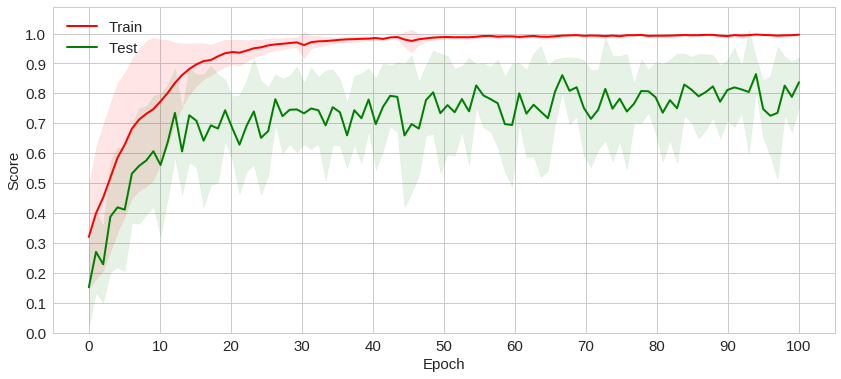

In [28]:
plot_mean_acc(history)

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

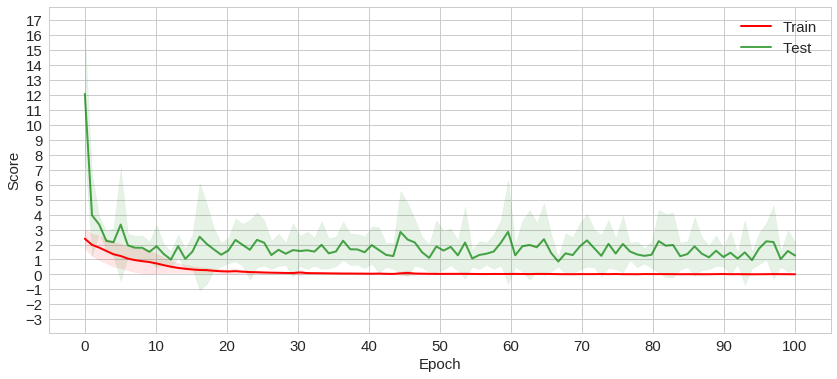

In [32]:
plot_mean_loss(history)